In [1]:
import numpy as np

# Import algorithms, operators and functions from CIL optimisation module
from cil.optimisation.algorithms import PDHG
from cil.optimisation.operators import BlockOperator, GradientOperator,\
                                       GradientOperator
from cil.optimisation.functions import IndicatorBox, MixedL21Norm, L2NormSquared, \
                                       BlockFunction, L1Norm, LeastSquares, \
                                       OperatorCompositionFunction, TotalVariation

# Import CIL Processors for preprocessing
from cil.processors import CentreOfRotationCorrector, Slicer, TransmissionAbsorptionConverter

# Import CIL utilities
from cil.utilities.display import show2D
from cil.utilities import dataexample

# Import from CIL ASTRA plugin
from cil.plugins.tigre import ProjectionOperator


# Import FBP from CIL recon class
from cil.recon import FBP, FDK

from cil.framework import ImageData

#Import Total Variation from the regularisation toolkit plugin
from cil.plugins.ccpi_regularisation.functions import FGP_TV

# All external imports
import matplotlib.pyplot as plt
import math

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

New geometry:  3D Cone-beam tomography
System configuration:
	Source position: [     0., -20000.,      0.]
	Rotation axis position: [0., 0., 0.]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [    0., 60000.,     0.]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [128 128]
	Pixel size: [64. 64.]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 60
	Angles 0-9 in degrees: [ 0.,  6., 12., 18., 24., 30., 36., 42., 48., 54.]
	Angles 50-59 in degrees: [300., 306., 312., 318., 324., 330., 336., 342., 348., 354.]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: units distance
Shape out:  (60, 128, 128)
New geometry shape:  (60, 128, 128)
FDK recon

Input Data:
	angle: 60
	vertical: 128
	horizontal: 128

Reconstruction Volume:
	vertical: 128
	horizontal_y: 128
	horizontal_x: 128

Reconstruction Options:
	

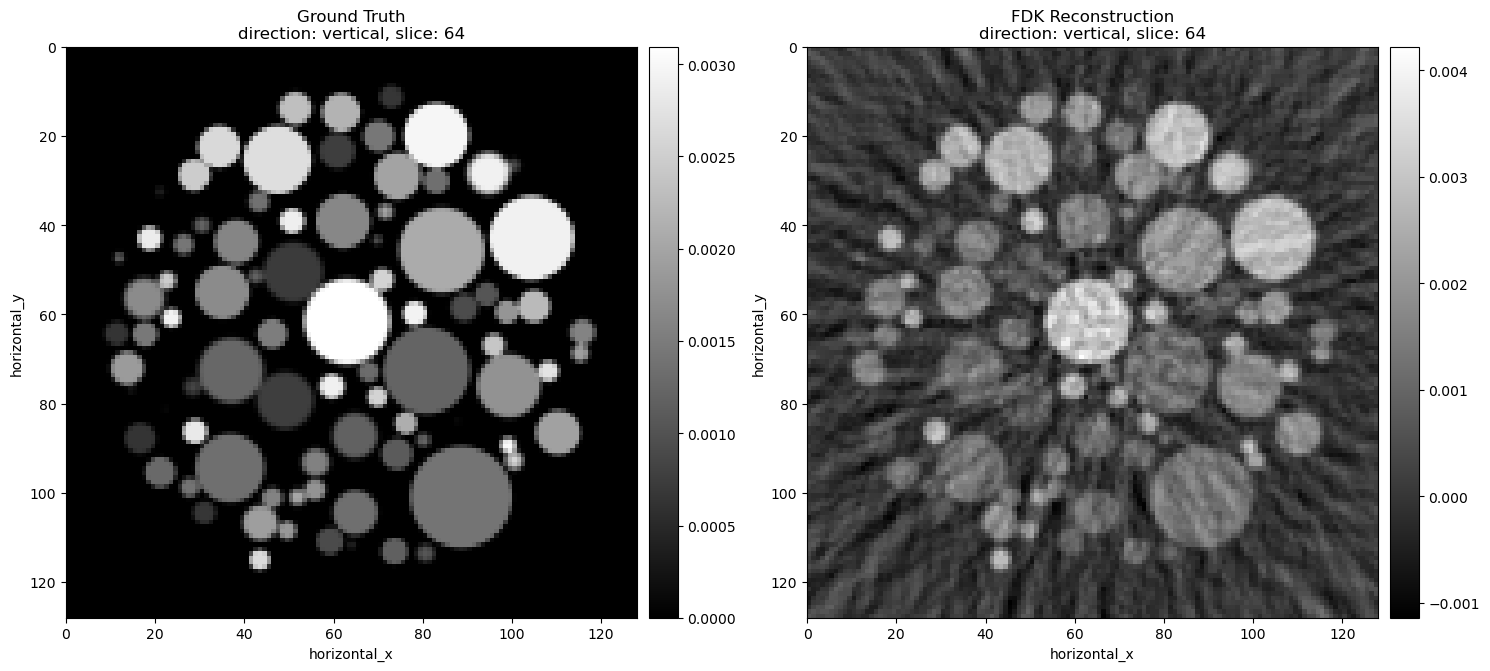

In [2]:
ground_truth = dataexample.SIMULATED_SPHERE_VOLUME.get()

data = dataexample.SIMULATED_CONE_BEAM_DATA.get()


absorption = TransmissionAbsorptionConverter()(data)
absorption = Slicer(roi={'angle':(0, -1, 5)})(absorption)

ig = ground_truth.geometry

recon = FDK(absorption, image_geometry=ig).run()
show2D([ground_truth, recon], title = ['Ground Truth', 'FDK Reconstruction'], origin = 'upper', num_cols = 2);

In [3]:
from cil.optimisation.utilities.callbacks import Callback, ProgressCallback

class SaveStepSizes(Callback):
    def __init__(self):
        super().__init__()
        self.tau = []
        self.sigma = []

    def __call__(self, algorithm):
        self.tau.append(algorithm.tau)
        self.sigma.append(algorithm.sigma)

In [4]:
A = ProjectionOperator(ig, absorption.geometry, device = "gpu")

In [5]:
print(A.norm())

1370.4285


In [6]:
# Test robustness to silly scaling
A*=1
absorption*=1

#  PDHG with implicit TV regularisation - adaptive vs non-adaptive - changing step size values 

In [7]:
F = 0.5 * L2NormSquared(b=absorption)
alpha = 0.5
G = alpha *  FGP_TV( device='gpu', nonnegativity=True)
rho = 1.0

step_size_list =  [1, 2, 5, 10, 20, 50, 100, 200]
step_size_list = [ a*1/A.norm() for a in step_size_list]
results_adaptive = []
objective_adaptive = []
sigma_values = []
tau_values = []
for step_size in step_size_list:
    print("sigma and tau = ", step_size)
    sigma = step_size
    tau = step_size
    pdhg_tv_explicit = PDHG(initial = [recon, A.direct(recon)/A.norm()], f = F, g = G, operator = A,
                update_objective_interval = 1, check_convergence=False, sigma=sigma, tau=tau, adaptive=True)
    callback=SaveStepSizes()
    pdhg_tv_explicit.run(200, verbose=1, callbacks=[ProgressCallback(), callback])
    results_adaptive.append(pdhg_tv_explicit.solution)
    objective_adaptive.append(pdhg_tv_explicit.objective)
    sigma_values.append(callback.sigma)
    tau_values.append(callback.tau)
    

sigma and tau =  0.0007296987943758322
Initial step sizes: tau = 0.0007296987943758322, sigma = 0.0007296987943758322


  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  0.96385413
x norm =  0.64170706
Backtracking condition value: 0.00021903171174364534
After possible reduction 0.0007296987943758322 0.0007296987943758322
2*self.p_norm < self.d_norm
After adaptive 3.6484939718791644e-05 0.014593975887516632 0.9025
x_tmp norm =  1.2065814
x norm =  0.6843432
Backtracking condition value: -0.014897934688902464
x_tmp norm =  0.79017955
x norm =  0.16465469
Step sizes reduced
Backtracking condition value: 0.0002683329687172886
After possible reduction 1.8242469859395822e-05 0.007296987943758316
2*self.p_norm < self.d_norm
After adaptive 1.7786408112910932e-06 0.07484090198726476 0.8573749999999999
x_tmp norm =  0.81271386
x norm =  0.03227803
Backtracking condition value: 0.0001666424199253117
After possible reduction 1.7786408112910932e-06 0.07484090198726476
2*self.p_norm < self.d_norm
After adaptive 2.536786457103924e-07 0.524739014809919 0.8145062499999999
x_tmp norm =  0.8362763
x norm =  0.031398546
Backtracking condition value: 0.00058

  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  0.98620117
x norm =  0.9794884
Backtracking condition value: 0.0005470820440207989
After possible reduction 0.0014593975887516645 0.0014593975887516645
2*self.p_norm < self.d_norm
After adaptive 7.296987943758329e-05 0.029187951775033263 0.9025
x_tmp norm =  4.5545683
x norm =  4.4004393
Backtracking condition value: -1.6340350088303826
x_tmp norm =  1.2810006
x norm =  1.1018939
Step sizes reduced
Backtracking condition value: -0.03780017139975589
x_tmp norm =  0.51220167
x norm =  0.27043608
Step sizes reduced
Backtracking condition value: 0.0006386505328817827
After possible reduction 1.8242469859395822e-05 0.007296987943758316
2*self.p_norm < self.d_norm
After adaptive 1.7786408112910932e-06 0.07484090198726476 0.8573749999999999
x_tmp norm =  0.54888326
x norm =  0.044203598
Backtracking condition value: 0.00045711202843116326
After possible reduction 1.7786408112910932e-06 0.07484090198726476
2*self.p_norm < self.d_norm
After adaptive 2.536786457103924e-07 0.5247390

  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  1.4199526
x norm =  1.2285087
Backtracking condition value: -0.008906162631551265
x_tmp norm =  1.0595288
x norm =  1.0906429
Step sizes reduced
Backtracking condition value: 0.0003962781600119528
After possible reduction 0.0018242469859395807 0.0018242469859395807
2*self.p_norm < self.d_norm
After adaptive 9.121234929697911e-05 0.03648493971879158 0.9025
x_tmp norm =  7.6340656
x norm =  7.5534844
Backtracking condition value: -6.1807051490218585
x_tmp norm =  1.9916012
x norm =  1.9055668
Step sizes reduced
Backtracking condition value: -0.16508385934128103
x_tmp norm =  0.5819922
x norm =  0.47233763
Step sizes reduced
Backtracking condition value: -0.0008752155319213251
x_tmp norm =  0.27311802
x norm =  0.11444235
Step sizes reduced
Backtracking condition value: 0.0005193205418354244
After possible reduction 1.1401543662122389e-05 0.004560617464848948
2*self.p_norm < self.d_norm
After adaptive 1.1116505070569333e-06 0.04677556374204048 0.8573749999999999
x_tmp norm =

  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  1.8220565
x norm =  1.2233374
Backtracking condition value: -0.03444189440836439
x_tmp norm =  1.4199526
x norm =  1.2285087
Step sizes reduced
Backtracking condition value: -0.008906162631551265
x_tmp norm =  1.0595288
x norm =  1.0906429
Step sizes reduced
Backtracking condition value: 0.0003962781600119528
After possible reduction 0.0018242469859395807 0.0018242469859395807
2*self.p_norm < self.d_norm
After adaptive 9.121234929697911e-05 0.03648493971879158 0.9025
x_tmp norm =  7.6340656
x norm =  7.5534844
Backtracking condition value: -6.1807051490218585
x_tmp norm =  1.9916012
x norm =  1.9055668
Step sizes reduced
Backtracking condition value: -0.16508385934128103
x_tmp norm =  0.5819922
x norm =  0.47233763
Step sizes reduced
Backtracking condition value: -0.0008752155319213251
x_tmp norm =  0.27311802
x norm =  0.11444235
Step sizes reduced
Backtracking condition value: 0.0005193205418354244
After possible reduction 1.1401543662122389e-05 0.004560617464848948
2*s

  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  12.917732
x norm =  11.0276575
Backtracking condition value: -13.56492580331334
x_tmp norm =  1.8220565
x norm =  1.2233374
Step sizes reduced
Backtracking condition value: -0.03444189440836439
x_tmp norm =  1.4199526
x norm =  1.2285087
Step sizes reduced
Backtracking condition value: -0.008906162631551265
x_tmp norm =  1.0595288
x norm =  1.0906429
Step sizes reduced
Backtracking condition value: 0.0003962781600119528
After possible reduction 0.0018242469859395807 0.0018242469859395807
2*self.p_norm < self.d_norm
After adaptive 9.121234929697911e-05 0.03648493971879158 0.9025
x_tmp norm =  7.6340656
x norm =  7.5534844
Backtracking condition value: -6.1807051490218585
x_tmp norm =  1.9916012
x norm =  1.9055668
Step sizes reduced
Backtracking condition value: -0.16508385934128103
x_tmp norm =  0.5819922
x norm =  0.47233763
Step sizes reduced
Backtracking condition value: -0.0008752155319213251
x_tmp norm =  0.27311802
x norm =  0.11444235
Step sizes reduced
Backtrackin

  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  118.65512
x norm =  114.5161
Backtracking condition value: -2042.4604727078886
x_tmp norm =  23.279995
x norm =  21.06553
Step sizes reduced
Backtracking condition value: -49.9119497227304
x_tmp norm =  3.2065382
x norm =  1.9243022
Step sizes reduced
Backtracking condition value: -0.38171194085859744
x_tmp norm =  1.4810127
x norm =  1.2292707
Step sizes reduced
Backtracking condition value: -0.02086011052980559
x_tmp norm =  1.16745
x norm =  1.1799184
Step sizes reduced
Backtracking condition value: -0.00041421645830400436
x_tmp norm =  0.94850963
x norm =  0.8499686
Step sizes reduced
Backtracking condition value: 0.0004524130621698038
After possible reduction 0.001140154366212238 0.001140154366212238
2*self.p_norm < self.d_norm
After adaptive 5.700771831061195e-05 0.022803087324244742 0.9025
x_tmp norm =  2.5941477
x norm =  2.33399
Backtracking condition value: -0.34146905452990095
x_tmp norm =  0.9050646
x norm =  0.5786264
Step sizes reduced
Backtracking condition

  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  514.4387
x norm =  505.40982
Backtracking condition value: -67828.57804314604
x_tmp norm =  118.65512
x norm =  114.5161
Step sizes reduced
Backtracking condition value: -2042.4604727078886
x_tmp norm =  23.279995
x norm =  21.06553
Step sizes reduced
Backtracking condition value: -49.9119497227304
x_tmp norm =  3.2065382
x norm =  1.9243022
Step sizes reduced
Backtracking condition value: -0.38171194085859744
x_tmp norm =  1.4810127
x norm =  1.2292707
Step sizes reduced
Backtracking condition value: -0.02086011052980559
x_tmp norm =  1.16745
x norm =  1.1799184
Step sizes reduced
Backtracking condition value: -0.00041421645830400436
x_tmp norm =  0.94850963
x norm =  0.8499686
Step sizes reduced
Backtracking condition value: 0.0004524130621698038
After possible reduction 0.001140154366212238 0.001140154366212238
2*self.p_norm < self.d_norm
After adaptive 5.700771831061195e-05 0.022803087324244742 0.9025
x_tmp norm =  2.5941477
x norm =  2.33399
Backtracking condition va

  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  2034.3196
x norm =  2012.4475
Backtracking condition value: -1994078.8528096983
x_tmp norm =  514.4387
x norm =  505.40982
Step sizes reduced
Backtracking condition value: -67828.57804314604
x_tmp norm =  118.65512
x norm =  114.5161
Step sizes reduced
Backtracking condition value: -2042.4604727078886
x_tmp norm =  23.279995
x norm =  21.06553
Step sizes reduced
Backtracking condition value: -49.9119497227304
x_tmp norm =  3.2065382
x norm =  1.9243022
Step sizes reduced
Backtracking condition value: -0.38171194085859744
x_tmp norm =  1.4810127
x norm =  1.2292707
Step sizes reduced
Backtracking condition value: -0.02086011052980559
x_tmp norm =  1.16745
x norm =  1.1799184
Step sizes reduced
Backtracking condition value: -0.00041421645830400436
x_tmp norm =  0.94850963
x norm =  0.8499686
Step sizes reduced
Backtracking condition value: 0.0004524130621698038
After possible reduction 0.001140154366212238 0.001140154366212238
2*self.p_norm < self.d_norm
After adaptive 5.70

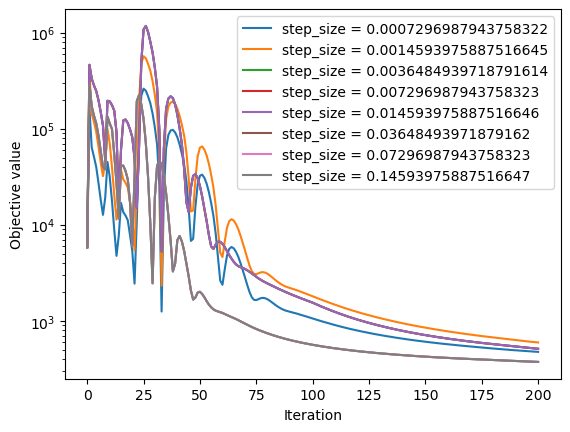

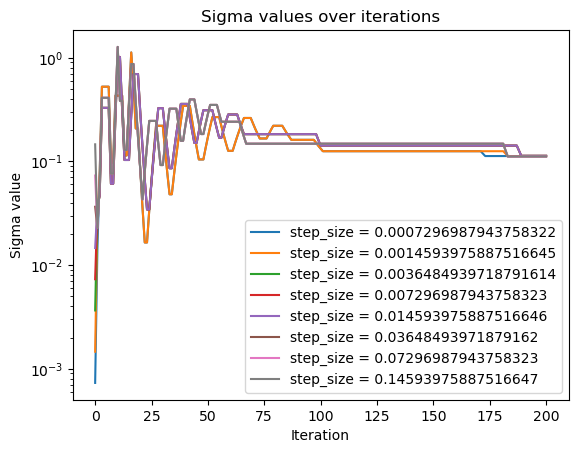

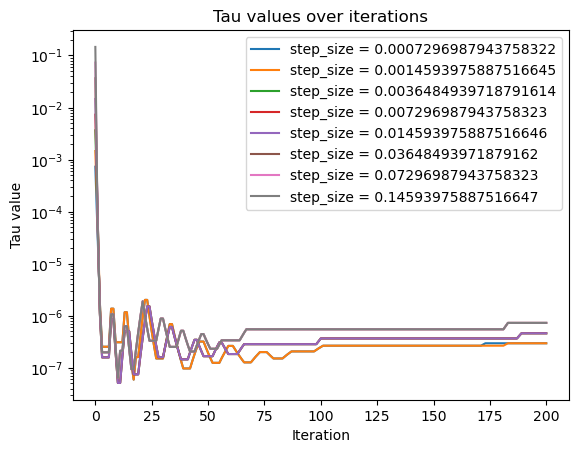

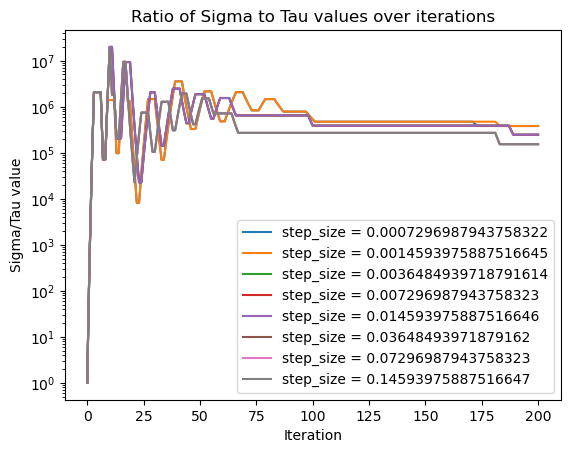

In [8]:
plt.figure()
for i, step_size in enumerate(step_size_list):
    plt.plot(range(0, 201, 1), objective_adaptive[i], label='step_size = ' + str(step_size))
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Objective value')
plt.legend()
plt.show()

plt.figure()
for i, step_size in enumerate(step_size_list):
    plt.plot(range(0, 201, 1), sigma_values[i], label='step_size = ' + str(step_size))
plt.title('Sigma values over iterations')
plt.xlabel('Iteration')
plt.ylabel('Sigma value')
plt.yscale('log')
plt.legend()
plt.show()

plt.figure()
for i, step_size in enumerate(step_size_list):
    plt.plot(range(0, 201, 1), tau_values[i], label='step_size = ' + str(step_size))
plt.title('Tau values over iterations')
plt.xlabel('Iteration')
plt.ylabel('Tau value')
plt.yscale('log')
plt.legend()
plt.show()

plt.figure()
for i, step_size in enumerate(step_size_list):
    #plt the ratio of sigma to tau
    plt.plot(range(0, 201, 1), np.array(sigma_values[i])/np.array(tau_values[i]), label='step_size = ' + str(step_size))
plt.title('Ratio of Sigma to Tau values over iterations')
plt.xlabel('Iteration')
plt.ylabel('Sigma/Tau value')
plt.yscale('log')
plt.legend()
plt.show()

In [9]:
F = 0.5 * L2NormSquared(b=absorption)
alpha = 0.5
G = alpha *  FGP_TV( device='gpu', nonnegativity=True)
rho = 1.0

step_size_list =  [1, 2, 5, 10, 20, 50, 100, 200]
step_size_list = [ a*1/A.norm() for a in step_size_list]
results_vanilla = []
objective_vanilla = []
for step_size in step_size_list:
    print("sigma and tau = ", step_size)
    sigma = step_size
    tau = step_size
    pdhg_tv_explicit = PDHG(f = F, g = G, operator = A,
                update_objective_interval = 1, check_convergence=False, sigma=sigma, tau=tau, adaptive=False)
    pdhg_tv_explicit.run(200, verbose=1, callbacks=[ProgressCallback()])
    results_vanilla.append(pdhg_tv_explicit.solution)
    objective_vanilla.append(pdhg_tv_explicit.objective)


sigma and tau =  0.0007296987943758322
Initial step sizes: tau = 0.0007296987943758322, sigma = 0.0007296987943758322


  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  0.723393
x norm =  0.7048431
x_tmp norm =  0.79029846
x norm =  0.17165905
x_tmp norm =  0.8757849
x norm =  0.18024951
x_tmp norm =  0.9725509
x norm =  0.16382605
x_tmp norm =  1.0579708
x norm =  0.13082239
x_tmp norm =  1.1045439
x norm =  0.1226378
x_tmp norm =  1.1452999
x norm =  0.12209532
x_tmp norm =  1.1949648
x norm =  0.11560919
x_tmp norm =  1.2478803
x norm =  0.10594714
x_tmp norm =  1.2955967
x norm =  0.095373005
x_tmp norm =  1.3339233
x norm =  0.08637498
x_tmp norm =  1.362588
x norm =  0.08013497
x_tmp norm =  1.3827882
x norm =  0.07600553
x_tmp norm =  1.3960408
x norm =  0.072599985
x_tmp norm =  1.4035044
x norm =  0.06925902
x_tmp norm =  1.4067256
x norm =  0.06558669
x_tmp norm =  1.4072696
x norm =  0.061573036
x_tmp norm =  1.4064444
x norm =  0.057370853
x_tmp norm =  1.4050363
x norm =  0.053543333
x_tmp norm =  1.4035542
x norm =  0.050309356
x_tmp norm =  1.4023232
x norm =  0.04763731
x_tmp norm =  1.401444
x norm =  0.045490455
x_tmp n

  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  2.8914645
x norm =  2.8504658
x_tmp norm =  13.998114
x norm =  2.8504658
x_tmp norm =  2.9247375
x norm =  0.062403083
x_tmp norm =  1.6607149
x norm =  1.1845449
x_tmp norm =  2.3946383
x norm =  0.9524899
x_tmp norm =  2.7702699
x norm =  2.3250222
x_tmp norm =  9.390767
x norm =  2.604512
x_tmp norm =  1.894273
x norm =  1.2931958
x_tmp norm =  4.1867094
x norm =  1.3044292
x_tmp norm =  2.3773437
x norm =  1.2447555
x_tmp norm =  3.9953136
x norm =  1.5343592
x_tmp norm =  3.682345
x norm =  1.8669136
x_tmp norm =  5.029512
x norm =  2.0599627
x_tmp norm =  4.682899
x norm =  2.0098538
x_tmp norm =  4.996496
x norm =  1.758195
x_tmp norm =  3.226545
x norm =  1.673079
x_tmp norm =  4.7767067
x norm =  1.8953744
x_tmp norm =  4.1161957
x norm =  1.8578544
x_tmp norm =  4.0871587
x norm =  1.7638154
x_tmp norm =  4.1352677
x norm =  1.8822303
x_tmp norm =  4.631699
x norm =  1.9186118
x_tmp norm =  3.9836795
x norm =  1.9234489
x_tmp norm =  4.7765765
x norm =  1.99435

  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  18.032192
x norm =  17.917978
x_tmp norm =  827.2425
x norm =  17.917978
x_tmp norm =  383.80072
x norm =  0.0
x_tmp norm =  364.60483
x norm =  0.0
x_tmp norm =  345.5031
x norm =  0.0
x_tmp norm =  326.4969
x norm =  0.0
x_tmp norm =  307.59293
x norm =  0.0
x_tmp norm =  288.7966
x norm =  0.0031550925
x_tmp norm =  270.11505
x norm =  0.04631498
x_tmp norm =  251.5606
x norm =  0.02318414
x_tmp norm =  233.14244
x norm =  0.052828934
x_tmp norm =  214.8849
x norm =  0.056300055
x_tmp norm =  196.79738
x norm =  0.14140719
x_tmp norm =  178.95442
x norm =  0.1756399
x_tmp norm =  161.30846
x norm =  0.33954984
x_tmp norm =  144.16135
x norm =  0.3474052
x_tmp norm =  127.24031
x norm =  0.4080407
x_tmp norm =  111.328415
x norm =  1.1469558
x_tmp norm =  98.991005
x norm =  1.56745
x_tmp norm =  88.58396
x norm =  3.3034265
x_tmp norm =  91.510376
x norm =  4.846745
x_tmp norm =  97.01984
x norm =  4.823257
x_tmp norm =  85.74829
x norm =  4.238015
x_tmp norm =  84.985

  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  71.86753
x norm =  71.62577
x_tmp norm =  13807.135
x norm =  71.62577
x_tmp norm =  6696.4194
x norm =  0.0
x_tmp norm =  6576.743
x norm =  0.0
x_tmp norm =  6457.9463
x norm =  0.0
x_tmp norm =  6340.0283
x norm =  0.0
x_tmp norm =  6222.9834
x norm =  0.0
x_tmp norm =  6106.8013
x norm =  0.0
x_tmp norm =  5991.4766
x norm =  0.0
x_tmp norm =  5877.0117
x norm =  0.0
x_tmp norm =  5763.395
x norm =  0.0
x_tmp norm =  5650.6294
x norm =  0.0
x_tmp norm =  5538.7017
x norm =  0.0
x_tmp norm =  5427.6006
x norm =  0.0
x_tmp norm =  5317.325
x norm =  0.0
x_tmp norm =  5207.875
x norm =  0.0
x_tmp norm =  5099.2437
x norm =  0.0
x_tmp norm =  4991.4253
x norm =  0.0
x_tmp norm =  4884.412
x norm =  0.0
x_tmp norm =  4778.2124
x norm =  0.0
x_tmp norm =  4672.8096
x norm =  0.0
x_tmp norm =  4568.2056
x norm =  0.0
x_tmp norm =  4464.394
x norm =  0.0
x_tmp norm =  4361.3745
x norm =  0.0
x_tmp norm =  4259.1426
x norm =  0.0
x_tmp norm =  4157.693
x norm =  0.04381966
x_t

  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  285.40265
x norm =  284.89908
x_tmp norm =  220517.3
x norm =  284.89908
x_tmp norm =  106660.23
x norm =  0.0
x_tmp norm =  104843.2
x norm =  0.0
x_tmp norm =  103052.39
x norm =  0.0
x_tmp norm =  101287.33
x norm =  0.0
x_tmp norm =  99547.54
x norm =  0.0
x_tmp norm =  97832.766
x norm =  0.0
x_tmp norm =  96142.7
x norm =  0.0
x_tmp norm =  94477.016
x norm =  0.0
x_tmp norm =  92835.38
x norm =  0.0
x_tmp norm =  91217.45
x norm =  0.0
x_tmp norm =  89622.82
x norm =  0.0
x_tmp norm =  88051.01
x norm =  0.0
x_tmp norm =  86501.805
x norm =  0.0
x_tmp norm =  84974.93
x norm =  0.0
x_tmp norm =  83470.086
x norm =  0.0
x_tmp norm =  81986.88
x norm =  0.0
x_tmp norm =  80525.03
x norm =  0.0
x_tmp norm =  79084.195
x norm =  0.0
x_tmp norm =  77664.125
x norm =  0.0
x_tmp norm =  76264.5
x norm =  0.0
x_tmp norm =  74885.016
x norm =  0.0
x_tmp norm =  73525.4
x norm =  0.0
x_tmp norm =  72185.4
x norm =  0.0
x_tmp norm =  70864.69
x norm =  0.0
x_tmp norm =  69563

  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  1746.0933
x norm =  1744.7904
x_tmp norm =  8286204.5
x norm =  1744.7904
x_tmp norm =  3848801.0
x norm =  0.0
x_tmp norm =  3711593.8
x norm =  0.0
x_tmp norm =  3579211.0
x norm =  0.0
x_tmp norm =  3451488.8
x norm =  0.0
x_tmp norm =  3328260.0
x norm =  0.0
x_tmp norm =  3209367.5
x norm =  0.0
x_tmp norm =  3094663.5
x norm =  0.0
x_tmp norm =  2984000.2
x norm =  0.0
x_tmp norm =  2877238.5
x norm =  0.0
x_tmp norm =  2774226.5
x norm =  0.0
x_tmp norm =  2674842.8
x norm =  0.0
x_tmp norm =  2578956.8
x norm =  0.0
x_tmp norm =  2486444.5
x norm =  0.0
x_tmp norm =  2397188.5
x norm =  0.0
x_tmp norm =  2311074.0
x norm =  0.0
x_tmp norm =  2227988.2
x norm =  0.0
x_tmp norm =  2147830.5
x norm =  0.0
x_tmp norm =  2070498.2
x norm =  0.0
x_tmp norm =  1995887.5
x norm =  0.0
x_tmp norm =  1923901.1
x norm =  0.0
x_tmp norm =  1854449.4
x norm =  0.0
x_tmp norm =  1787441.5
x norm =  0.0
x_tmp norm =  1722791.5
x norm =  0.0
x_tmp norm =  1660416.8
x norm =  0.0


  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  6746.878
x norm =  6744.2314
x_tmp norm =  123802376.0
x norm =  6744.2314
x_tmp norm =  53471390.0
x norm =  0.0
x_tmp norm =  49828160.0
x norm =  0.0
x_tmp norm =  46432884.0
x norm =  0.0
x_tmp norm =  43268464.0
x norm =  0.0
x_tmp norm =  40319216.0
x norm =  0.0
x_tmp norm =  37570460.0
x norm =  0.0
x_tmp norm =  35008624.0
x norm =  0.0
x_tmp norm =  32621196.0
x norm =  0.0
x_tmp norm =  30396048.0
x norm =  0.0
x_tmp norm =  28322202.0
x norm =  0.0
x_tmp norm =  26389358.0
x norm =  0.0
x_tmp norm =  24587946.0
x norm =  0.0
x_tmp norm =  22909164.0
x norm =  0.0
x_tmp norm =  21344506.0
x norm =  0.0
x_tmp norm =  19886224.0
x norm =  0.0
x_tmp norm =  18527104.0
x norm =  0.0
x_tmp norm =  17260406.0
x norm =  0.0
x_tmp norm =  16079924.0
x norm =  0.0
x_tmp norm =  14979704.0
x norm =  0.0
x_tmp norm =  13954277.0
x norm =  0.0
x_tmp norm =  12998575.0
x norm =  0.0
x_tmp norm =  12107870.0
x norm =  0.0
x_tmp norm =  11277788.0
x norm =  0.0
x_tmp norm =  

  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  25269.016
x norm =  25263.686
x_tmp norm =  1737007100.0
x norm =  25263.686
x_tmp norm =  647250800.0
x norm =  0.0
x_tmp norm =  564793900.0
x norm =  0.0
x_tmp norm =  492841860.0
x norm =  0.0
x_tmp norm =  430050980.0
x norm =  0.0
x_tmp norm =  375257250.0
x norm =  0.0
x_tmp norm =  327442530.0
x norm =  0.0
x_tmp norm =  285715300.0
x norm =  0.0
x_tmp norm =  249303980.0
x norm =  0.0
x_tmp norm =  217529090.0
x norm =  0.0
x_tmp norm =  189800620.0
x norm =  0.0
x_tmp norm =  165604200.0
x norm =  0.0
x_tmp norm =  144488370.0
x norm =  0.0
x_tmp norm =  126062460.0
x norm =  0.0
x_tmp norm =  109982920.0
x norm =  0.0
x_tmp norm =  95950904.0
x norm =  0.0
x_tmp norm =  83706430.0
x norm =  0.0
x_tmp norm =  73020840.0
x norm =  0.0
x_tmp norm =  63696400.0
x norm =  0.0
x_tmp norm =  55559416.0
x norm =  0.0
x_tmp norm =  48458532.0
x norm =  0.0
x_tmp norm =  42262264.0
x norm =  0.0
x_tmp norm =  36854870.0
x norm =  0.0
x_tmp norm =  32136260.0
x norm =  0.

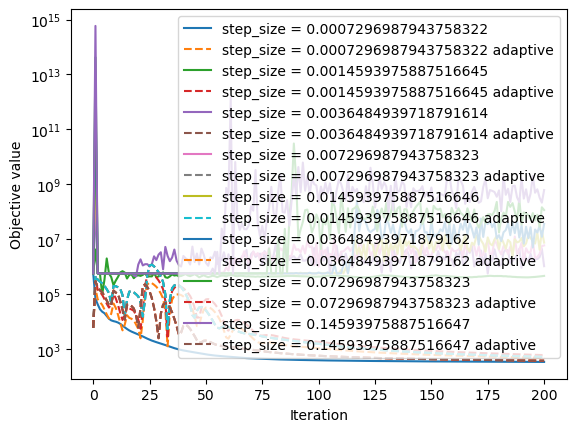

In [10]:
for i, step_size in enumerate(step_size_list):
    plt.plot(range(0, 201, 1), objective_vanilla[i], label='step_size = ' + str(step_size))
    plt.plot(range(0, 201, 1), objective_adaptive[i], label='step_size = ' + str(step_size)+' adaptive', linestyle='dashed')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Objective value')
plt.legend()
plt.show()

#  PDHG with implicit TV regularisation - adaptive vs non-adaptive - changing gamma 

In [11]:
F = 0.5 * L2NormSquared(b=absorption)
alpha = 0.5
G = alpha *  FGP_TV( device='gpu', nonnegativity=True)
rho = 1.0

gamma_list =  [ 100, 1000,  0.01, 0.1, 1, 10]
results_adaptive = []
objective_adaptive = []
sigma_values = []
tau_values = []
for gamma in gamma_list:
    print("gamma = ", gamma)
    sigma = gamma*rho/A.norm()
    tau =(rho/gamma)/A.norm() 
    pdhg_tv_implicit = PDHG(f = F, g = G, operator = A,
                update_objective_interval = 1, check_convergence=False, sigma=sigma, tau=tau, adaptive=True)#, eta=.95, initial=[recon, None]) 
    callback=SaveStepSizes()
    pdhg_tv_implicit.run(200, verbose=1, callbacks=[ProgressCallback(), callback])
    results_adaptive.append(pdhg_tv_implicit.solution)
    objective_adaptive.append(pdhg_tv_implicit.objective)
    sigma_values.append(callback.sigma)
    tau_values.append(callback.tau)
    

gamma =  100
Initial step sizes: tau = 7.296987943758323e-06, sigma = 0.07296987943758323


  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  0.67468894
x norm =  0.67442465
Backtracking condition value: -0.06874716000426673
x_tmp norm =  0.17460963
x norm =  0.17447944
Step sizes reduced
Backtracking condition value: 0.0011340075993377403
After possible reduction 3.6484939718791615e-06 0.03648493971879162
2*self.p_norm < self.d_norm
After adaptive 1.8242469859395823e-07 0.7296987943758317 0.9025
x_tmp norm =  0.23499466
x norm =  0.06078206
Backtracking condition value: 0.00357763171606635
After possible reduction 1.8242469859395823e-07 0.7296987943758317
No change
After adaptive 1.8242469859395823e-07 0.7296987943758317 0.9025
x_tmp norm =  0.33339027
x norm =  0.09853536
Backtracking condition value: 0.00033526948384565367
After possible reduction 1.8242469859395823e-07 0.7296987943758317
No change
After adaptive 1.8242469859395823e-07 0.7296987943758317 0.9025
x_tmp norm =  0.4348957
x norm =  0.10173331
Backtracking condition value: 0.006152068023247907
After possible reduction 1.8242469859395823e-07 0.729

  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  0.41852355
x norm =  0.4184969
Backtracking condition value: -0.26463473731597165
x_tmp norm =  0.13260065
x norm =  0.13258721
Step sizes reduced
Backtracking condition value: 0.006530222604565854
After possible reduction 3.6484939718791614e-07 0.36484939718791615
No change
After adaptive 3.6484939718791614e-07 0.36484939718791615 0.95
x_tmp norm =  0.31498808
x norm =  0.18243301
Backtracking condition value: 0.002445627813098988
After possible reduction 3.6484939718791614e-07 0.36484939718791615
No change
After adaptive 3.6484939718791614e-07 0.36484939718791615 0.95
x_tmp norm =  0.49299526
x norm =  0.17827909
Backtracking condition value: 0.010196015179011725
After possible reduction 3.6484939718791614e-07 0.36484939718791615
No change
After adaptive 3.6484939718791614e-07 0.36484939718791615 0.95
x_tmp norm =  0.63809884
x norm =  0.14609662
Backtracking condition value: 0.002154804781344416
After possible reduction 3.6484939718791614e-07 0.36484939718791615
2*self

  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  0.72391576
x norm =  0.65375996
Backtracking condition value: -6.247269791851943e-06
x_tmp norm =  0.1809796
x norm =  0.16344059
Step sizes reduced
Backtracking condition value: 1.738267409561796e-07
After possible reduction 0.03648493971879162 3.6484939718791615e-06
2*self.p_norm < self.d_norm
After adaptive 0.0018242469859395824 7.296987943758317e-05 0.9025
x_tmp norm =  0.26879337
x norm =  0.090107925
Backtracking condition value: 2.4036873087646553e-06
After possible reduction 0.0018242469859395824 7.296987943758317e-05
2*self.p_norm < self.d_norm
After adaptive 0.00017786408112910933 0.0007484090198726476 0.8573749999999999
x_tmp norm =  0.35451633
x norm =  0.10877406
Backtracking condition value: 1.585032440795254e-05
After possible reduction 0.00017786408112910933 0.0007484090198726476
2*self.p_norm < self.d_norm
After adaptive 2.5367864571039238e-05 0.00524739014809919 0.8145062499999999
x_tmp norm =  0.43350896
x norm =  0.08704094
Backtracking condition value

  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  0.7238681
x norm =  0.6553465
Backtracking condition value: -6.344328500376955e-05
x_tmp norm =  0.18097363
x norm =  0.16343522
Step sizes reduced
Backtracking condition value: 1.738156056362833e-06
After possible reduction 0.0036484939718791614 3.648493971879162e-05
2*self.p_norm < self.d_norm
After adaptive 0.00018242469859395822 0.0007296987943758317 0.9025
x_tmp norm =  0.2687183
x norm =  0.10995206
Backtracking condition value: 1.6387264300582618e-05
After possible reduction 0.00018242469859395822 0.0007296987943758317
2*self.p_norm < self.d_norm
After adaptive 1.7786408112910933e-05 0.007484090198726477 0.8573749999999999
x_tmp norm =  0.36377913
x norm =  0.10101609
Backtracking condition value: 0.0001245485845421846
After possible reduction 1.7786408112910933e-05 0.007484090198726477
2*self.p_norm < self.d_norm
After adaptive 2.536786457103924e-06 0.05247390148099191 0.8145062499999999
x_tmp norm =  0.4415502
x norm =  0.08037415
Backtracking condition value: 0.

  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  0.723393
x norm =  0.7048431
Backtracking condition value: -0.0007628121343083968
x_tmp norm =  0.18091428
x norm =  0.17280166
Step sizes reduced
Backtracking condition value: 1.3769764812173625e-05
After possible reduction 0.0003648493971879161 0.0003648493971879161
2*self.p_norm < self.d_norm
After adaptive 1.8242469859395822e-05 0.007296987943758316 0.9025
x_tmp norm =  0.27643162
x norm =  0.10510779
Backtracking condition value: 0.00013341106197937714
After possible reduction 1.8242469859395822e-05 0.007296987943758316
2*self.p_norm < self.d_norm
After adaptive 1.7786408112910932e-06 0.07484090198726476 0.8573749999999999
x_tmp norm =  0.36790296
x norm =  0.09269684
Backtracking condition value: 0.0010053472311657334
After possible reduction 1.7786408112910932e-06 0.07484090198726476
2*self.p_norm < self.d_norm
After adaptive 2.536786457103924e-07 0.524739014809919 0.8145062499999999
x_tmp norm =  0.42238504
x norm =  0.055171974
Backtracking condition value: 0.002

  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  0.718677
x norm =  0.71626025
Backtracking condition value: -0.007772205955774935
x_tmp norm =  0.1803224
x norm =  0.17918037
Step sizes reduced
Backtracking condition value: 0.00012267722668575222
After possible reduction 3.648493971879162e-05 0.0036484939718791614
2*self.p_norm < self.d_norm
After adaptive 1.8242469859395824e-06 0.07296987943758317 0.9025
x_tmp norm =  0.27472645
x norm =  0.09604484
Backtracking condition value: 0.001073278258182144
After possible reduction 1.8242469859395824e-06 0.07296987943758317
2*self.p_norm < self.d_norm
After adaptive 1.7786408112910935e-07 0.7484090198726476 0.8573749999999999
x_tmp norm =  0.33244306
x norm =  0.05795934
Backtracking condition value: 0.003041263649638847
After possible reduction 1.7786408112910935e-07 0.7484090198726476
No change
After adaptive 1.7786408112910935e-07 0.7484090198726476 0.8573749999999999
x_tmp norm =  0.41533193
x norm =  0.08310351
Backtracking condition value: 0.0010033022074951775
After po

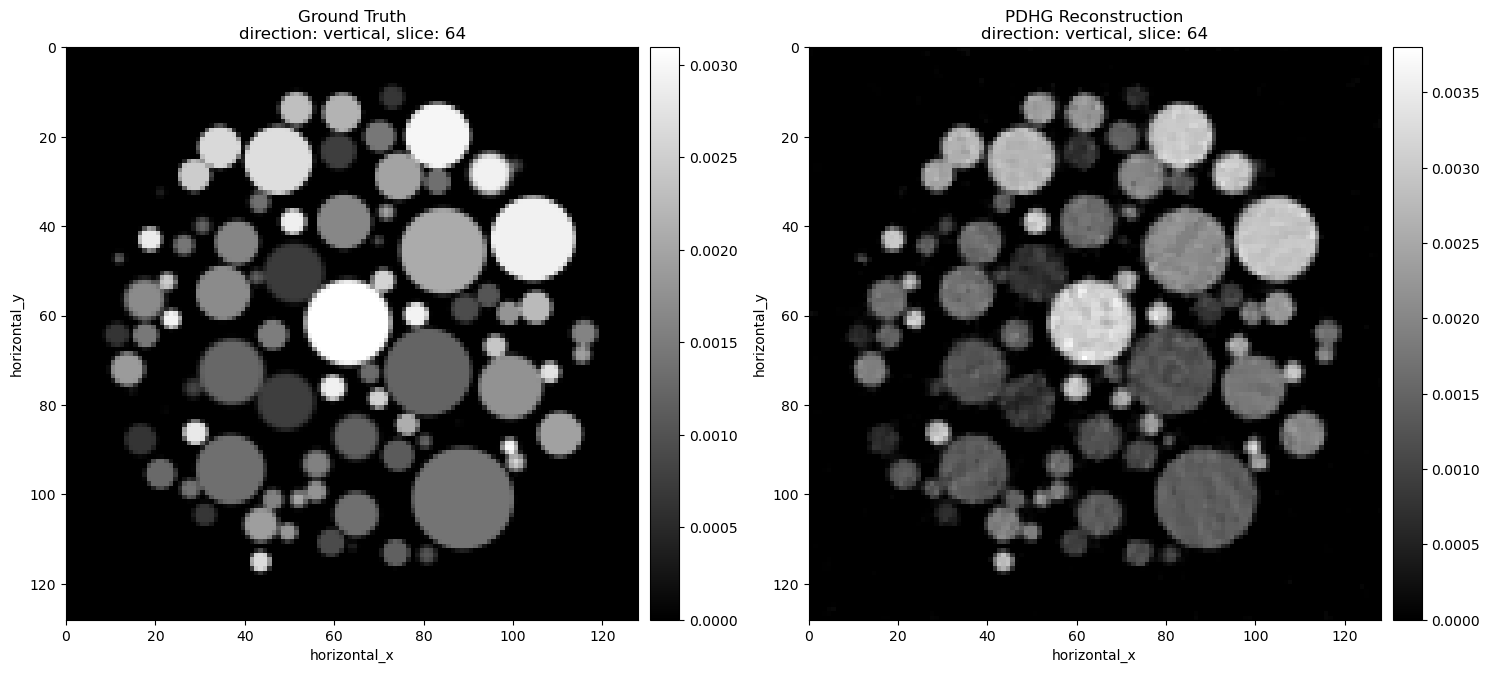

In [12]:
show2D([ground_truth, pdhg_tv_implicit.solution], title = ['Ground Truth', 'PDHG Reconstruction'], origin = 'upper', num_cols = 2);

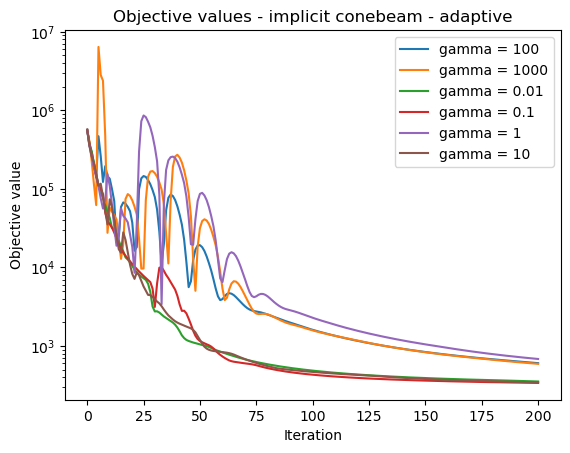

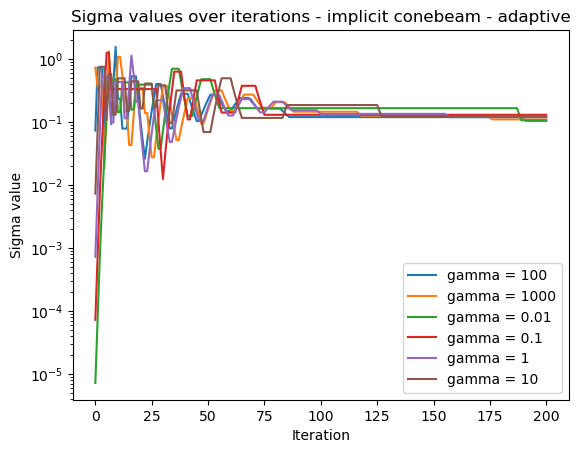

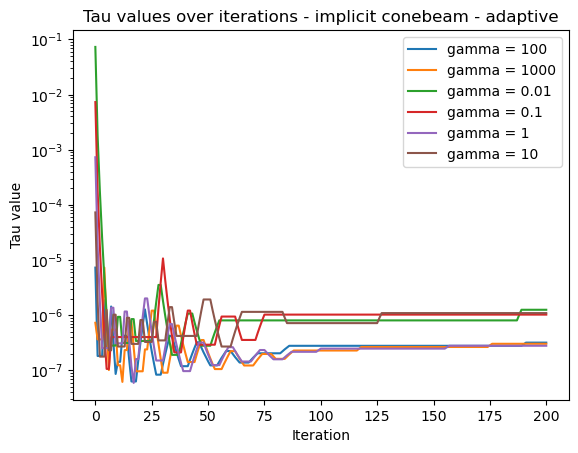

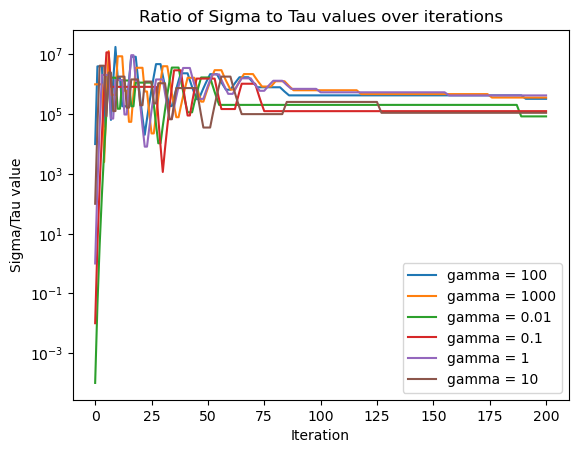

In [13]:
plt.figure()
for i, gamma in enumerate(gamma_list):
    plt.plot(range(0, 201, 1), objective_adaptive[i], label='gamma = ' + str(gamma))
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Objective value')
plt.title('Objective values - implicit conebeam - adaptive')
plt.legend()
plt.show()

plt.figure()
for i, gamma in enumerate(gamma_list):
    plt.plot(range(0, 201, 1), sigma_values[i], label='gamma = ' + str(gamma))
plt.title('Sigma values over iterations - implicit conebeam - adaptive')
plt.xlabel('Iteration')
plt.ylabel('Sigma value')
plt.yscale('log')
plt.legend()
plt.show()

plt.figure()
for i, gamma in enumerate(gamma_list):
    plt.plot(range(0, 201, 1), tau_values[i], label='gamma = ' + str(gamma))
plt.title('Tau values over iterations - implicit conebeam - adaptive')
plt.xlabel('Iteration')
plt.ylabel('Tau value')
plt.yscale('log')
plt.legend()
plt.show()

plt.figure()
for i, gamma in enumerate(gamma_list):
    #plt the ratio of sigma to tau
    plt.plot(range(0, 201, 1), np.array(sigma_values[i])/np.array(tau_values[i]), label='gamma = ' + str(gamma))
plt.title('Ratio of Sigma to Tau values over iterations')
plt.xlabel('Iteration')
plt.ylabel('Sigma/Tau value')
plt.yscale('log')
plt.legend()
plt.show()

In [14]:
F = 0.5 * L2NormSquared(b=absorption)
alpha = 0.5
G = alpha *  FGP_TV( device='gpu', nonnegativity=True)
rho = 1.0

gamma_list = [0.01, 0.1, 1, 10, 100, 1000]
results_vanilla = []
objective_vanilla = []
for gamma in gamma_list:
    print("gamma = ", gamma)
    sigma = gamma*rho/A.norm()
    tau =(rho/gamma)/A.norm() 
    pdhg_tv_implicit = PDHG(f = F, g = G, operator = A,
                update_objective_interval = 1, check_convergence=False, sigma=sigma, tau=tau)
    pdhg_tv_implicit.run(200, verbose=1)
    results_vanilla.append(pdhg_tv_implicit.solution)
    objective_vanilla.append(pdhg_tv_implicit.objective)
    

gamma =  0.01
Initial step sizes: tau = 0.07296987943758323, sigma = 7.296987943758323e-06


  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  0.72391576
x norm =  0.65375996
x_tmp norm =  0.86551374
x norm =  0.093021415
x_tmp norm =  1.0190696
x norm =  0.09542048
x_tmp norm =  1.1780317
x norm =  0.07904712
x_tmp norm =  1.337004
x norm =  0.06636916
x_tmp norm =  1.4902617
x norm =  0.05709961
x_tmp norm =  1.6397531
x norm =  0.052946556
x_tmp norm =  1.7894595
x norm =  0.048020303
x_tmp norm =  1.9409882
x norm =  0.045938678
x_tmp norm =  2.0954137
x norm =  0.044797707
x_tmp norm =  2.2525797
x norm =  0.045285426
x_tmp norm =  2.4114952
x norm =  0.046767823
x_tmp norm =  2.571379
x norm =  0.051492162
x_tmp norm =  2.7310905
x norm =  0.058332022
x_tmp norm =  2.8884068
x norm =  0.06347214
x_tmp norm =  3.0409591
x norm =  0.06387351
x_tmp norm =  3.1867878
x norm =  0.06393383
x_tmp norm =  3.324962
x norm =  0.06557504
x_tmp norm =  3.4553275
x norm =  0.06512923
x_tmp norm =  3.5780988
x norm =  0.06311257
x_tmp norm =  3.6937482
x norm =  0.061240755
x_tmp norm =  3.8030143
x norm =  0.06137774
x

  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  0.7238681
x norm =  0.6553465
x_tmp norm =  0.86119187
x norm =  0.16613752
x_tmp norm =  0.9685519
x norm =  0.13104488
x_tmp norm =  1.0556644
x norm =  0.118081585
x_tmp norm =  1.1326481
x norm =  0.10796085
x_tmp norm =  1.1916453
x norm =  0.08942206
x_tmp norm =  1.2356256
x norm =  0.07322988
x_tmp norm =  1.2712442
x norm =  0.06408667
x_tmp norm =  1.3031409
x norm =  0.060260106
x_tmp norm =  1.3342862
x norm =  0.0583237
x_tmp norm =  1.3661293
x norm =  0.056602392
x_tmp norm =  1.3988448
x norm =  0.054440174
x_tmp norm =  1.43195
x norm =  0.05186383
x_tmp norm =  1.4647924
x norm =  0.04931913
x_tmp norm =  1.496669
x norm =  0.046986766
x_tmp norm =  1.5272024
x norm =  0.045126636
x_tmp norm =  1.556287
x norm =  0.043800175
x_tmp norm =  1.5838853
x norm =  0.04281988
x_tmp norm =  1.6100729
x norm =  0.041904338
x_tmp norm =  1.6349307
x norm =  0.040800583
x_tmp norm =  1.6585275
x norm =  0.0392912
x_tmp norm =  1.6808606
x norm =  0.037365004
x_tmp 

  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  0.723393
x norm =  0.7048431
x_tmp norm =  0.79029846
x norm =  0.17165905
x_tmp norm =  0.8757849
x norm =  0.18024951
x_tmp norm =  0.9725509
x norm =  0.16382605
x_tmp norm =  1.0579708
x norm =  0.13082239
x_tmp norm =  1.1045439
x norm =  0.1226378
x_tmp norm =  1.1452999
x norm =  0.12209532
x_tmp norm =  1.1949648
x norm =  0.11560919
x_tmp norm =  1.2478803
x norm =  0.10594714
x_tmp norm =  1.2955967
x norm =  0.095373005
x_tmp norm =  1.3339233
x norm =  0.08637498
x_tmp norm =  1.362588
x norm =  0.08013497
x_tmp norm =  1.3827882
x norm =  0.07600553
x_tmp norm =  1.3960408
x norm =  0.072599985
x_tmp norm =  1.4035044
x norm =  0.06925902
x_tmp norm =  1.4067256
x norm =  0.06558669
x_tmp norm =  1.4072696
x norm =  0.061573036
x_tmp norm =  1.4064444
x norm =  0.057370853
x_tmp norm =  1.4050363
x norm =  0.053543333
x_tmp norm =  1.4035542
x norm =  0.050309356
x_tmp norm =  1.4023232
x norm =  0.04763731
x_tmp norm =  1.401444
x norm =  0.045490455
x_tmp n

  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  0.718677
x norm =  0.71626025
x_tmp norm =  0.7806115
x norm =  0.18523015
x_tmp norm =  0.8753742
x norm =  0.19671081
x_tmp norm =  0.9847885
x norm =  0.17486246
x_tmp norm =  1.0733749
x norm =  0.15106079
x_tmp norm =  1.1349113
x norm =  0.14497288
x_tmp norm =  1.1957322
x norm =  0.1351071
x_tmp norm =  1.2566216
x norm =  0.11970703
x_tmp norm =  1.3078802
x norm =  0.10294131
x_tmp norm =  1.3446486
x norm =  0.08838697
x_tmp norm =  1.367669
x norm =  0.078186475
x_tmp norm =  1.380443
x norm =  0.07138605
x_tmp norm =  1.3864019
x norm =  0.066966996
x_tmp norm =  1.388234
x norm =  0.06355965
x_tmp norm =  1.3877128
x norm =  0.06031565
x_tmp norm =  1.3857938
x norm =  0.05690548
x_tmp norm =  1.3829848
x norm =  0.053393997
x_tmp norm =  1.3796237
x norm =  0.049956653
x_tmp norm =  1.37599
x norm =  0.0468884
x_tmp norm =  1.3723389
x norm =  0.044375397
x_tmp norm =  1.3688868
x norm =  0.04243888
x_tmp norm =  1.3657846
x norm =  0.0409174
x_tmp norm =  

  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  0.67468894
x norm =  0.67442465
x_tmp norm =  0.76813537
x norm =  0.17970361
x_tmp norm =  0.85419893
x norm =  0.18167049
x_tmp norm =  0.950068
x norm =  0.16123974
x_tmp norm =  1.0307618
x norm =  0.13677341
x_tmp norm =  1.0880694
x norm =  0.124827564
x_tmp norm =  1.1381913
x norm =  0.11466603
x_tmp norm =  1.1859207
x norm =  0.10097306
x_tmp norm =  1.2270555
x norm =  0.08656907
x_tmp norm =  1.2585998
x norm =  0.07351701
x_tmp norm =  1.2804888
x norm =  0.06327151
x_tmp norm =  1.2944975
x norm =  0.055946596
x_tmp norm =  1.3028362
x norm =  0.050667856
x_tmp norm =  1.3073295
x norm =  0.046554882
x_tmp norm =  1.309267
x norm =  0.043024044
x_tmp norm =  1.3095655
x norm =  0.039678287
x_tmp norm =  1.3088402
x norm =  0.036447886
x_tmp norm =  1.3075186
x norm =  0.03343241
x_tmp norm =  1.3059175
x norm =  0.030749772
x_tmp norm =  1.3042653
x norm =  0.028466325
x_tmp norm =  1.3027029
x norm =  0.02658997
x_tmp norm =  1.3013023
x norm =  0.025039418

  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  0.41852355
x norm =  0.4184969
x_tmp norm =  0.6098571
x norm =  0.19831952
x_tmp norm =  0.7089401
x norm =  0.11782988
x_tmp norm =  0.7695167
x norm =  0.08715768
x_tmp norm =  0.81246096
x norm =  0.07079497
x_tmp norm =  0.84595025
x norm =  0.05924364
x_tmp norm =  0.87346405
x norm =  0.050365105
x_tmp norm =  0.89666396
x norm =  0.04349512
x_tmp norm =  0.9165497
x norm =  0.038210016
x_tmp norm =  0.9339239
x norm =  0.03407051
x_tmp norm =  0.9494136
x norm =  0.030723745
x_tmp norm =  0.9634601
x norm =  0.027937274
x_tmp norm =  0.9763564
x norm =  0.02556892
x_tmp norm =  0.98830116
x norm =  0.023524132
x_tmp norm =  0.9994269
x norm =  0.021741273
x_tmp norm =  1.0098274
x norm =  0.02017381
x_tmp norm =  1.019575
x norm =  0.018787323
x_tmp norm =  1.0287292
x norm =  0.017551811
x_tmp norm =  1.0373408
x norm =  0.016443394
x_tmp norm =  1.04545
x norm =  0.015445349
x_tmp norm =  1.0530963
x norm =  0.014541499
x_tmp norm =  1.060315
x norm =  0.0137195

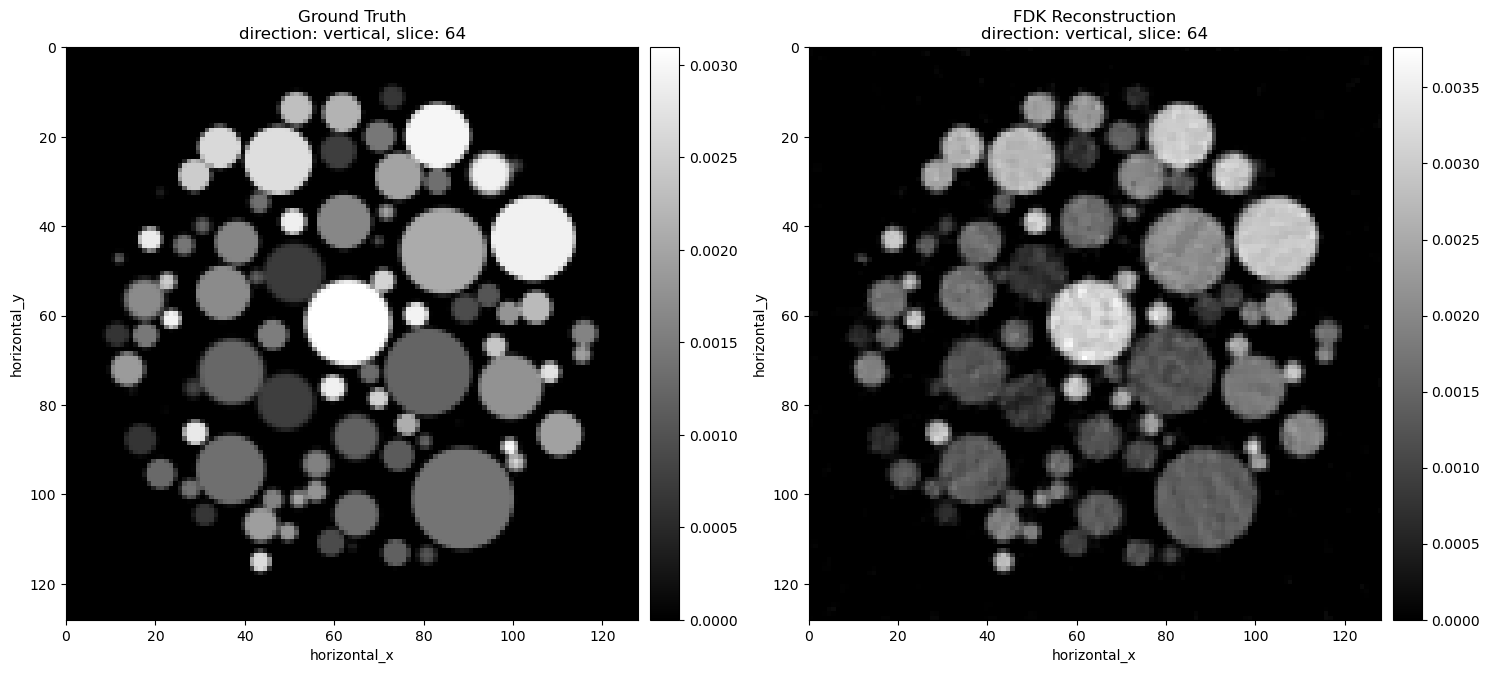

In [15]:
show2D([ground_truth, pdhg_tv_implicit.solution], title = ['Ground Truth', 'FDK Reconstruction'], origin = 'upper', num_cols = 2);

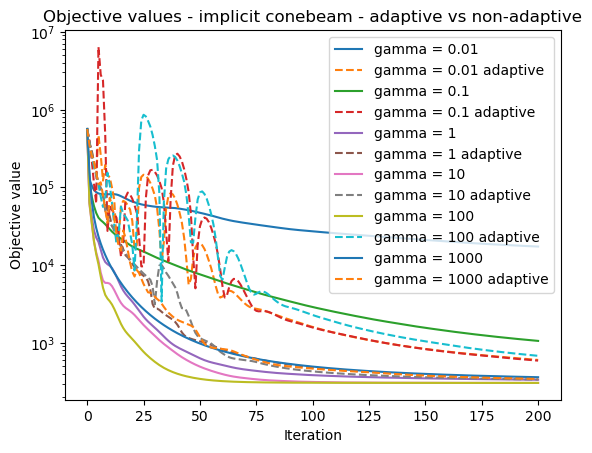

In [16]:
for i, gamma in enumerate(gamma_list):
    plt.plot(range(0, 201, 1), objective_vanilla[i], label='gamma = ' + str(gamma))
    plt.plot(range(0, 201, 1), objective_adaptive[i], label='gamma = ' + str(gamma)+' adaptive', linestyle='dashed')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Objective value')
plt.title('Objective values - implicit conebeam - adaptive vs non-adaptive')
plt.legend()
plt.show()

# PDHG with Explicit TV - adaptive vs non-adaptive

In [17]:
# Vanilla TV with reg parameter in front of Mixed L21 Norm
alpha = 0.5
G = IndicatorBox(lower=0)
rho = 1.0
f1 =  alpha *MixedL21Norm()
f2 = 0.5 * L2NormSquared(b=absorption)
F = BlockFunction(f1, f2)

# Define BlockOperator K
Grad =  GradientOperator(ig)
K = BlockOperator(Grad, A)



gamma_list = [0.01, 0.1, 1, 10, 100, 1000]
results_vanilla = []
objective_vanilla = []
for gamma in gamma_list:
    print("gamma = ", gamma)
    sigma = gamma*rho/K.norm()
    tau =(rho/gamma)/K.norm() 
    pdhg_tv_explicit = PDHG(f = F, g = G, operator = K,
                update_objective_interval = 1, check_convergence=False, sigma=sigma, tau=tau)
    pdhg_tv_explicit.run(200, verbose=1)
    results_vanilla.append(pdhg_tv_explicit.solution)
    objective_vanilla.append(pdhg_tv_explicit.objective)



gamma =  0.01
Initial step sizes: tau = 0.07296987852695279, sigma = 7.296987852695279e-06


  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  0.72391576
x norm =  0.72391576
x_tmp norm =  0.7814509
x norm =  0.1912294
x_tmp norm =  0.88119316
x norm =  0.2028839
x_tmp norm =  0.9957105
x norm =  0.17862692
x_tmp norm =  1.0842357
x norm =  0.15739349
x_tmp norm =  1.1522716
x norm =  0.14954202
x_tmp norm =  1.217977
x norm =  0.1365816
x_tmp norm =  1.2785422
x norm =  0.11944888
x_tmp norm =  1.3267826
x norm =  0.10216204
x_tmp norm =  1.3603358
x norm =  0.08801444
x_tmp norm =  1.3810523
x norm =  0.07819003
x_tmp norm =  1.3923769
x norm =  0.07209254
x_tmp norm =  1.3976893
x norm =  0.068300486
x_tmp norm =  1.3995689
x norm =  0.06549697
x_tmp norm =  1.3995702
x norm =  0.062956214
x_tmp norm =  1.398493
x norm =  0.06026154
x_tmp norm =  1.3967152
x norm =  0.057423443
x_tmp norm =  1.3944737
x norm =  0.054658238
x_tmp norm =  1.3920188
x norm =  0.052221015
x_tmp norm =  1.3896393
x norm =  0.050304286
x_tmp norm =  1.3876075
x norm =  0.048898805
x_tmp norm =  1.3861108
x norm =  0.04789712
x_tmp 

  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  0.7238681
x norm =  0.7238681
x_tmp norm =  0.7814404
x norm =  0.19121292
x_tmp norm =  0.88116634
x norm =  0.20286381
x_tmp norm =  0.99566543
x norm =  0.17860942
x_tmp norm =  1.0841826
x norm =  0.1573717
x_tmp norm =  1.1522056
x norm =  0.149517
x_tmp norm =  1.2178936
x norm =  0.13655959
x_tmp norm =  1.2784454
x norm =  0.11943018
x_tmp norm =  1.3266785
x norm =  0.10214563
x_tmp norm =  1.3602293
x norm =  0.08799821
x_tmp norm =  1.3809453
x norm =  0.07817276
x_tmp norm =  1.3922708
x norm =  0.0720733
x_tmp norm =  1.3975843
x norm =  0.06827948
x_tmp norm =  1.3994634
x norm =  0.06547438
x_tmp norm =  1.3994638
x norm =  0.06293209
x_tmp norm =  1.3983846
x norm =  0.060236484
x_tmp norm =  1.3966048
x norm =  0.057397783
x_tmp norm =  1.3943605
x norm =  0.054631878
x_tmp norm =  1.3919036
x norm =  0.052193996
x_tmp norm =  1.3895218
x norm =  0.05027658
x_tmp norm =  1.3874875
x norm =  0.048870277
x_tmp norm =  1.3859879
x norm =  0.047867645
x_tmp n

  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  0.723393
x norm =  0.723393
x_tmp norm =  0.7813367
x norm =  0.19104947
x_tmp norm =  0.8808978
x norm =  0.20266306
x_tmp norm =  0.9952138
x norm =  0.17843509
x_tmp norm =  1.0836502
x norm =  0.15715422
x_tmp norm =  1.1515447
x norm =  0.14926738
x_tmp norm =  1.2170631
x norm =  0.13633971
x_tmp norm =  1.2774822
x norm =  0.119243555
x_tmp norm =  1.3256404
x norm =  0.10198185
x_tmp norm =  1.3591629
x norm =  0.08783639
x_tmp norm =  1.3798777
x norm =  0.07800071
x_tmp norm =  1.3912137
x norm =  0.07188149
x_tmp norm =  1.3965353
x norm =  0.06806988
x_tmp norm =  1.3984138
x norm =  0.06524887
x_tmp norm =  1.3984039
x norm =  0.06269168
x_tmp norm =  1.3973068
x norm =  0.05998649
x_tmp norm =  1.3955044
x norm =  0.05714203
x_tmp norm =  1.3932382
x norm =  0.054368895
x_tmp norm =  1.3907596
x norm =  0.051925104
x_tmp norm =  1.3883554
x norm =  0.05000083
x_tmp norm =  1.3862964
x norm =  0.048586283
x_tmp norm =  1.3847669
x norm =  0.047574297
x_tmp no

  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  0.718677
x norm =  0.718677
x_tmp norm =  0.78028005
x norm =  0.1894906
x_tmp norm =  0.8782457
x norm =  0.20067014
x_tmp norm =  0.9907488
x norm =  0.1767132
x_tmp norm =  1.0783917
x norm =  0.15501888
x_tmp norm =  1.1450461
x norm =  0.14680079
x_tmp norm =  1.2089003
x norm =  0.13416642
x_tmp norm =  1.2680093
x norm =  0.1174013
x_tmp norm =  1.3154374
x norm =  0.1003686
x_tmp norm =  1.3486925
x norm =  0.08625018
x_tmp norm =  1.3694164
x norm =  0.07633061
x_tmp norm =  1.3808888
x norm =  0.07001194
x_tmp norm =  1.3863283
x norm =  0.06603688
x_tmp norm =  1.3882458
x norm =  0.06306501
x_tmp norm =  1.3881845
x norm =  0.060364306
x_tmp norm =  1.3869618
x norm =  0.057577938
x_tmp norm =  1.3850037
x norm =  0.05466764
x_tmp norm =  1.3825758
x norm =  0.051830925
x_tmp norm =  1.3799384
x norm =  0.04933457
x_tmp norm =  1.377372
x norm =  0.04734047
x_tmp norm =  1.3751249
x norm =  0.04584749
x_tmp norm =  1.3733641
x norm =  0.044760086
x_tmp norm = 

  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  0.67468894
x norm =  0.67468894
x_tmp norm =  0.7681536
x norm =  0.1802064
x_tmp norm =  0.8545888
x norm =  0.18220566
x_tmp norm =  0.95087487
x norm =  0.1612776
x_tmp norm =  1.0312209
x norm =  0.13710818
x_tmp norm =  1.0889227
x norm =  0.12518948
x_tmp norm =  1.1396148
x norm =  0.11470439
x_tmp norm =  1.1874492
x norm =  0.10088697
x_tmp norm =  1.2283736
x norm =  0.08642503
x_tmp norm =  1.2596323
x norm =  0.07340924
x_tmp norm =  1.2813295
x norm =  0.063213296
x_tmp norm =  1.2952636
x norm =  0.055920277
x_tmp norm =  1.3036033
x norm =  0.05067976
x_tmp norm =  1.3081516
x norm =  0.046633255
x_tmp norm =  1.3101969
x norm =  0.04314805
x_tmp norm =  1.3106325
x norm =  0.039862934
x_tmp norm =  1.3100636
x norm =  0.036696453
x_tmp norm =  1.3089111
x norm =  0.03373892
x_tmp norm =  1.3074809
x norm =  0.031114513
x_tmp norm =  1.3060015
x norm =  0.028884161
x_tmp norm =  1.3046175
x norm =  0.027052388
x_tmp norm =  1.3034002
x norm =  0.025540523
x

  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  0.41852358
x norm =  0.41852358
x_tmp norm =  0.6098686
x norm =  0.19834498
x_tmp norm =  0.70897555
x norm =  0.1178798
x_tmp norm =  0.7695872
x norm =  0.08722425
x_tmp norm =  0.8125753
x norm =  0.07087137
x_tmp norm =  0.84611404
x norm =  0.05932028
x_tmp norm =  0.8736758
x norm =  0.05043185
x_tmp norm =  0.89690906
x norm =  0.043555874
x_tmp norm =  0.91681606
x norm =  0.038271315
x_tmp norm =  0.9342091
x norm =  0.03413492
x_tmp norm =  0.9497202
x norm =  0.030791543
x_tmp norm =  0.9637918
x norm =  0.028007774
x_tmp norm =  0.9767175
x norm =  0.025640016
x_tmp norm =  0.9886925
x norm =  0.023596304
x_tmp norm =  0.9998506
x norm =  0.021813208
x_tmp norm =  1.0102828
x norm =  0.020245064
x_tmp norm =  1.0200615
x norm =  0.018858131
x_tmp norm =  1.029247
x norm =  0.017620463
x_tmp norm =  1.037887
x norm =  0.016510786
x_tmp norm =  1.0460235
x norm =  0.015511809
x_tmp norm =  1.0536957
x norm =  0.014606519
x_tmp norm =  1.0609384
x norm =  0.0137

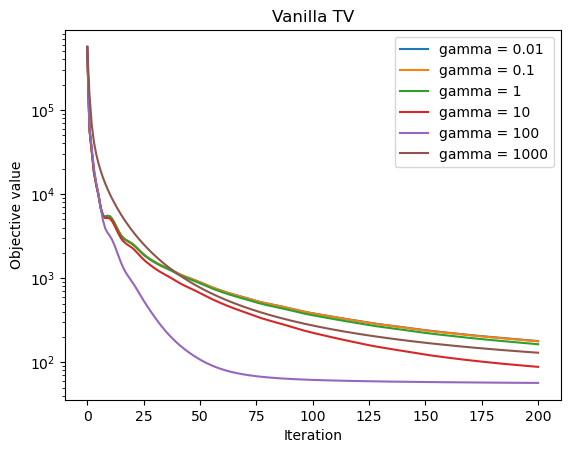

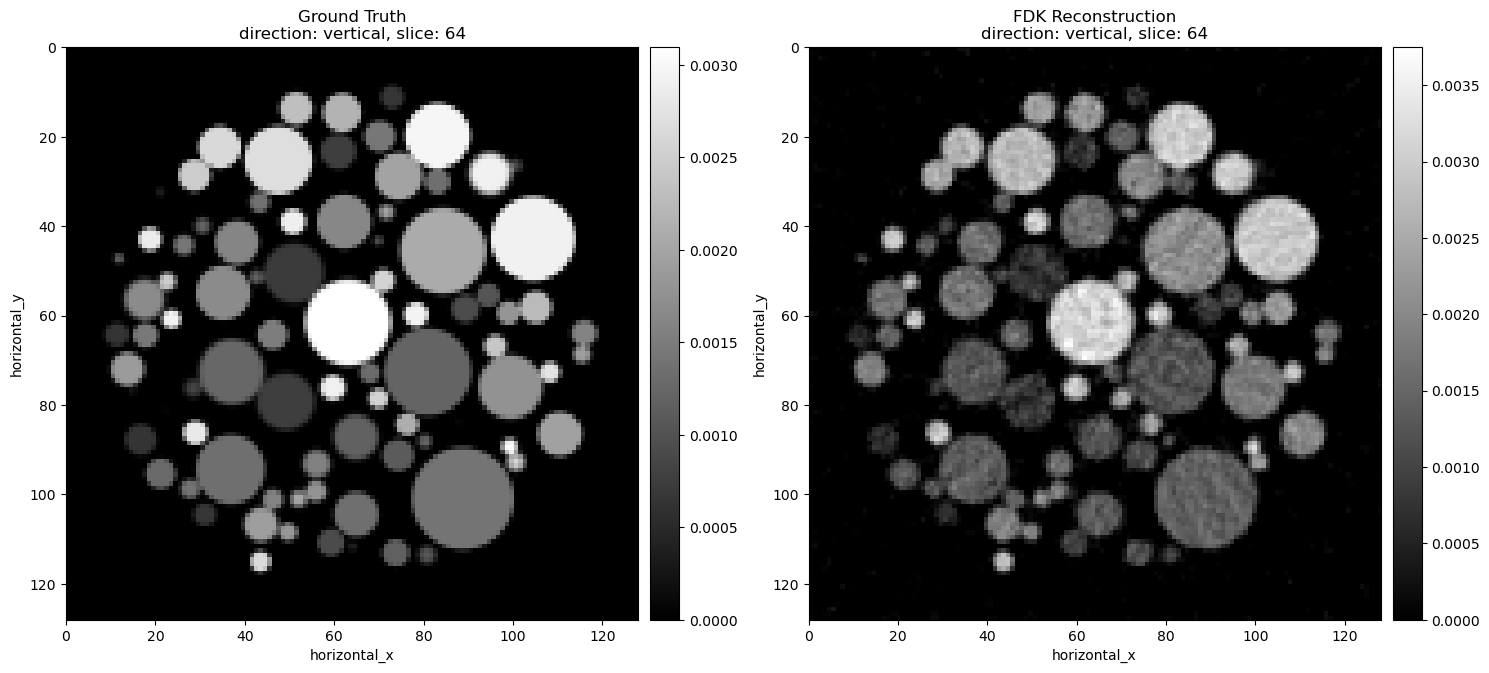

129.91418365865366
0.0


In [18]:

    
for i, gamma in enumerate(gamma_list):
    plt.plot(range(0, 201, 1), objective_vanilla[i], label='gamma = ' + str(gamma))
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Objective value')
plt.legend()
plt.title('Vanilla TV')
plt.show()

show2D([ground_truth, pdhg_tv_explicit.solution], title = ['Ground Truth', 'FDK Reconstruction'], origin = 'upper', num_cols = 2);

print( F(K.direct(pdhg_tv_explicit.solution)) )
print( G(pdhg_tv_explicit.solution) )


In [19]:
#   Vanilla TV with reg parameter in front of gradient operator

alpha = 0.5
G = IndicatorBox(lower=0)
rho = 1.0
f1 =  MixedL21Norm()
f2 = 0.5 * L2NormSquared(b=absorption)
F = BlockFunction(f1, f2)

# Define BlockOperator K
Grad = alpha * GradientOperator(ig)
K = BlockOperator(Grad, A)



gamma_list = [0.01, 0.1, 1, 10, 100, 1000]
results_vanilla = []
objective_vanilla = []
for gamma in gamma_list:
    print("gamma = ", gamma)
    sigma = gamma*rho/K.norm()
    tau =(rho/gamma)/K.norm() 
    pdhg_tv_explicit = PDHG(f = F, g = G, operator = K,
                update_objective_interval = 1, check_convergence=False, sigma=sigma, tau=tau)
    pdhg_tv_explicit.run(200, verbose=1)
    results_vanilla.append(pdhg_tv_explicit.solution)
    objective_vanilla.append(pdhg_tv_explicit.objective)
    


gamma =  0.01
Initial step sizes: tau = 0.0729698792099256, sigma = 7.296987920992562e-06


  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  0.72391576
x norm =  0.72391576
x_tmp norm =  0.7814509
x norm =  0.1912294
x_tmp norm =  0.88119316
x norm =  0.2028839
x_tmp norm =  0.9957105
x norm =  0.17862692
x_tmp norm =  1.0842357
x norm =  0.15739349
x_tmp norm =  1.1522716
x norm =  0.14954202
x_tmp norm =  1.217977
x norm =  0.1365816
x_tmp norm =  1.2785422
x norm =  0.11944888
x_tmp norm =  1.3267826
x norm =  0.10216204
x_tmp norm =  1.3603358
x norm =  0.08801444
x_tmp norm =  1.3810523
x norm =  0.07819003
x_tmp norm =  1.3923769
x norm =  0.07209254
x_tmp norm =  1.3976893
x norm =  0.068300486
x_tmp norm =  1.3995689
x norm =  0.06549697
x_tmp norm =  1.3995702
x norm =  0.062956214
x_tmp norm =  1.398493
x norm =  0.060261544
x_tmp norm =  1.3967153
x norm =  0.057423446
x_tmp norm =  1.3944738
x norm =  0.05465824
x_tmp norm =  1.3920188
x norm =  0.05222102
x_tmp norm =  1.3896393
x norm =  0.05030429
x_tmp norm =  1.3876076
x norm =  0.04889881
x_tmp norm =  1.3861108
x norm =  0.047897123
x_tmp no

  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  0.7238681
x norm =  0.7238681
x_tmp norm =  0.7814404
x norm =  0.19121292
x_tmp norm =  0.88116634
x norm =  0.20286381
x_tmp norm =  0.99566543
x norm =  0.17860942
x_tmp norm =  1.0841826
x norm =  0.1573717
x_tmp norm =  1.1522056
x norm =  0.149517
x_tmp norm =  1.2178936
x norm =  0.13655959
x_tmp norm =  1.2784454
x norm =  0.11943018
x_tmp norm =  1.3266786
x norm =  0.10214563
x_tmp norm =  1.3602293
x norm =  0.08799821
x_tmp norm =  1.3809453
x norm =  0.078172766
x_tmp norm =  1.3922708
x norm =  0.0720733
x_tmp norm =  1.3975843
x norm =  0.06827948
x_tmp norm =  1.3994634
x norm =  0.06547438
x_tmp norm =  1.3994638
x norm =  0.06293209
x_tmp norm =  1.3983846
x norm =  0.060236488
x_tmp norm =  1.3966048
x norm =  0.057397783
x_tmp norm =  1.3943605
x norm =  0.05463188
x_tmp norm =  1.3919036
x norm =  0.052194
x_tmp norm =  1.389522
x norm =  0.05027659
x_tmp norm =  1.3874875
x norm =  0.048870284
x_tmp norm =  1.3859879
x norm =  0.047867652
x_tmp norm 

x_tmp norm =  1.396323
x norm =  0.03046225
x_tmp norm =  1.3969444
x norm =  0.030073721
x_tmp norm =  1.397464
x norm =  0.02971888
x_tmp norm =  1.397874
x norm =  0.02938257
x_tmp norm =  1.39817
x norm =  0.029054606
x_tmp norm =  1.3983551
x norm =  0.028730607
x_tmp norm =  1.398439
x norm =  0.028409028
x_tmp norm =  1.3984392
x norm =  0.028081933
x_tmp norm =  1.398374
x norm =  0.027755676
x_tmp norm =  1.3982605
x norm =  0.027435184
x_tmp norm =  1.3981155
x norm =  0.027120678
x_tmp norm =  1.3979546
x norm =  0.0268153
x_tmp norm =  1.3977916
x norm =  0.026517687
x_tmp norm =  1.3976415
x norm =  0.026232012
x_tmp norm =  1.3975179
x norm =  0.025951965
x_tmp norm =  1.3974378
x norm =  0.0256713
x_tmp norm =  1.3974063
x norm =  0.025390062
x_tmp norm =  1.3974266
x norm =  0.025111238
x_tmp norm =  1.3974977
x norm =  0.024833096
x_tmp norm =  1.3976179
x norm =  0.024558937
x_tmp norm =  1.3977846
x norm =  0.02429679
x_tmp norm =  1.397994
x norm =  0.024046695
x_tm

  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  0.723393
x norm =  0.723393
x_tmp norm =  0.7813367
x norm =  0.19104947
x_tmp norm =  0.8808978
x norm =  0.20266306
x_tmp norm =  0.9952138
x norm =  0.17843509
x_tmp norm =  1.0836502
x norm =  0.15715422
x_tmp norm =  1.1515448
x norm =  0.14926738
x_tmp norm =  1.2170631
x norm =  0.13633971
x_tmp norm =  1.2774822
x norm =  0.119243555
x_tmp norm =  1.3256404
x norm =  0.10198185
x_tmp norm =  1.3591629
x norm =  0.08783639
x_tmp norm =  1.3798777
x norm =  0.07800071
x_tmp norm =  1.3912137
x norm =  0.07188149
x_tmp norm =  1.3965353
x norm =  0.06806988
x_tmp norm =  1.3984138
x norm =  0.06524887
x_tmp norm =  1.3984039
x norm =  0.06269168
x_tmp norm =  1.3973068
x norm =  0.05998649
x_tmp norm =  1.3955044
x norm =  0.057142038
x_tmp norm =  1.3932382
x norm =  0.0543689
x_tmp norm =  1.3907596
x norm =  0.051925104
x_tmp norm =  1.3883554
x norm =  0.05000084
x_tmp norm =  1.3862965
x norm =  0.04858629
x_tmp norm =  1.3847669
x norm =  0.0475743
x_tmp norm =

  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  0.718677
x norm =  0.718677
x_tmp norm =  0.78028005
x norm =  0.1894906
x_tmp norm =  0.8782457
x norm =  0.20067014
x_tmp norm =  0.9907488
x norm =  0.1767132
x_tmp norm =  1.0783917
x norm =  0.15501888
x_tmp norm =  1.1450462
x norm =  0.14680079
x_tmp norm =  1.2089003
x norm =  0.13416642
x_tmp norm =  1.2680093
x norm =  0.11740131
x_tmp norm =  1.3154374
x norm =  0.1003686
x_tmp norm =  1.3486925
x norm =  0.086250186
x_tmp norm =  1.3694164
x norm =  0.07633061
x_tmp norm =  1.3808888
x norm =  0.07001194
x_tmp norm =  1.3863283
x norm =  0.06603688
x_tmp norm =  1.3882458
x norm =  0.063065015
x_tmp norm =  1.3881845
x norm =  0.060364306
x_tmp norm =  1.3869619
x norm =  0.05757794
x_tmp norm =  1.3850037
x norm =  0.054667644
x_tmp norm =  1.3825758
x norm =  0.05183093
x_tmp norm =  1.3799384
x norm =  0.049334574
x_tmp norm =  1.377372
x norm =  0.047340475
x_tmp norm =  1.3751249
x norm =  0.045847494
x_tmp norm =  1.3733642
x norm =  0.044760093
x_tmp no

  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  0.67468894
x norm =  0.67468894
x_tmp norm =  0.7681536
x norm =  0.1802064
x_tmp norm =  0.8545888
x norm =  0.18220566
x_tmp norm =  0.95087487
x norm =  0.1612776
x_tmp norm =  1.0312209
x norm =  0.13710818
x_tmp norm =  1.0889227
x norm =  0.12518948
x_tmp norm =  1.1396148
x norm =  0.11470439
x_tmp norm =  1.1874492
x norm =  0.10088697
x_tmp norm =  1.2283736
x norm =  0.08642503
x_tmp norm =  1.2596323
x norm =  0.07340924
x_tmp norm =  1.2813295
x norm =  0.0632133
x_tmp norm =  1.2952636
x norm =  0.05592028
x_tmp norm =  1.3036033
x norm =  0.05067976
x_tmp norm =  1.3081516
x norm =  0.046633262
x_tmp norm =  1.3101969
x norm =  0.04314805
x_tmp norm =  1.3106325
x norm =  0.03986294
x_tmp norm =  1.3100636
x norm =  0.036696456
x_tmp norm =  1.3089111
x norm =  0.033738922
x_tmp norm =  1.3074809
x norm =  0.031114517
x_tmp norm =  1.3060015
x norm =  0.028884165
x_tmp norm =  1.3046176
x norm =  0.027052393
x_tmp norm =  1.3034003
x norm =  0.025540527
x_tm

  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  0.41852355
x norm =  0.41852355
x_tmp norm =  0.6098686
x norm =  0.19834495
x_tmp norm =  0.70897555
x norm =  0.11787979
x_tmp norm =  0.76958716
x norm =  0.087224245
x_tmp norm =  0.81257516
x norm =  0.07087136
x_tmp norm =  0.846114
x norm =  0.059320275
x_tmp norm =  0.87367576
x norm =  0.050431848
x_tmp norm =  0.89690894
x norm =  0.04355587
x_tmp norm =  0.916816
x norm =  0.03827131
x_tmp norm =  0.93420905
x norm =  0.034134913
x_tmp norm =  0.9497201
x norm =  0.030791542
x_tmp norm =  0.9637917
x norm =  0.028007772
x_tmp norm =  0.9767174
x norm =  0.025640015
x_tmp norm =  0.9886924
x norm =  0.023596304
x_tmp norm =  0.99985045
x norm =  0.021813208
x_tmp norm =  1.0102826
x norm =  0.020245064
x_tmp norm =  1.0200614
x norm =  0.018858131
x_tmp norm =  1.029247
x norm =  0.017620463
x_tmp norm =  1.0378869
x norm =  0.016510788
x_tmp norm =  1.0460234
x norm =  0.015511811
x_tmp norm =  1.0536956
x norm =  0.0146065205
x_tmp norm =  1.0609384
x norm =  

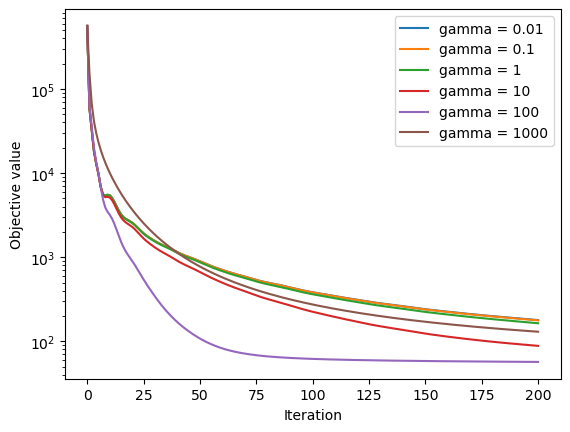

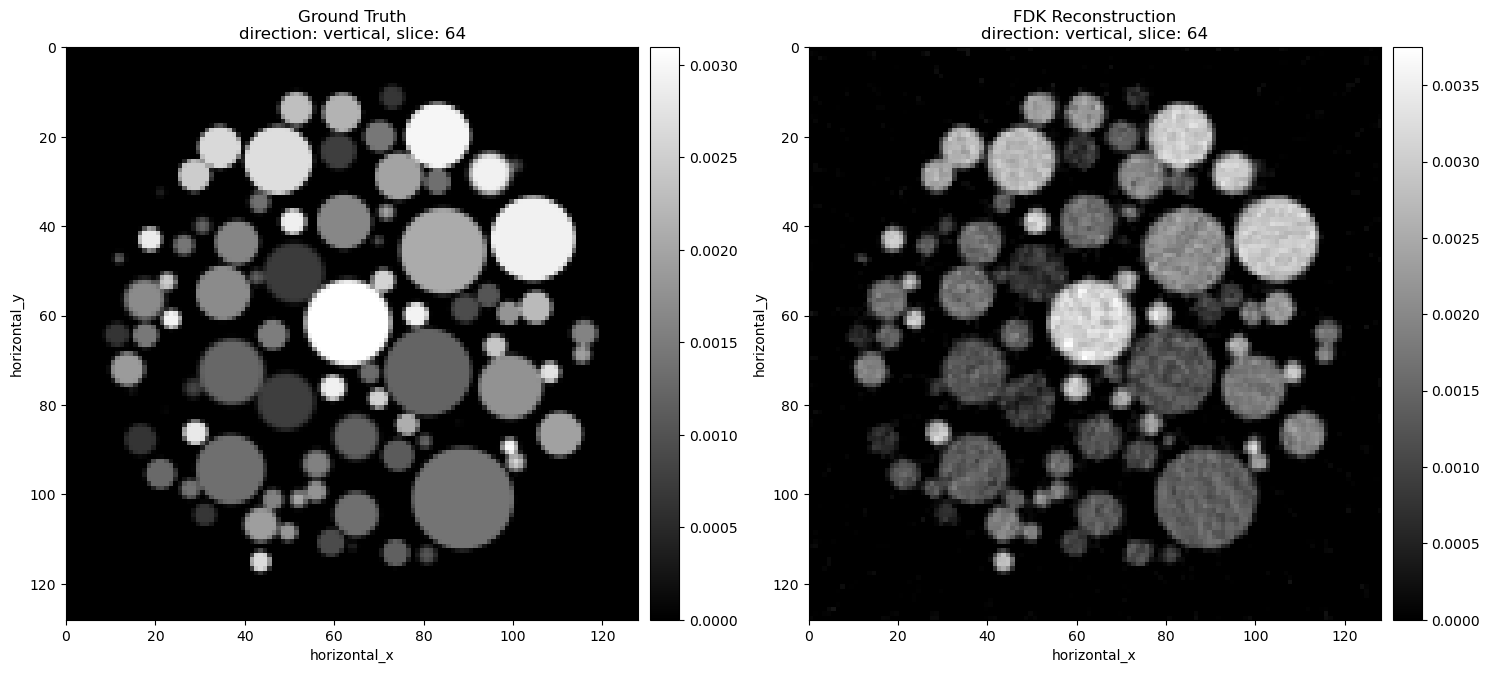

129.90757889729377
0.0


In [20]:

for i, gamma in enumerate(gamma_list):
    plt.plot(range(0, 201, 1), objective_vanilla[i], label='gamma = ' + str(gamma))
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Objective value')
plt.legend()
plt.show()

show2D([ground_truth, pdhg_tv_explicit.solution], title = ['Ground Truth', 'FDK Reconstruction'], origin = 'upper', num_cols = 2);

print( F(K.direct(pdhg_tv_explicit.solution)) )
print( G(pdhg_tv_explicit.solution) )


In [21]:
alpha = 0.5
G = IndicatorBox(lower=0)
rho = 1.0
f1 =  MixedL21Norm()
f2 = 0.5 * L2NormSquared(b=absorption)
F = BlockFunction(f1, f2)

# Define BlockOperator K
Grad = alpha * GradientOperator(ig)
K = BlockOperator(Grad, A)


gamma_list =  [ 100, 1000, 0.01, 0.1, 1, 10]
results_adaptive = []
objective_adaptive = []
sigma_values = []
tau_values = []
for gamma in gamma_list:
    print("gamma = ", gamma)
    sigma = gamma*rho/A.norm()
    tau =(rho/gamma)/A.norm() 
    pdhg_tv_explicit = PDHG(f = F, g = G, operator = K,
                update_objective_interval = 1, check_convergence=False, sigma=sigma, tau=tau, adaptive=True)#, eta=.95, initial=[recon, None]) 
    callback=SaveStepSizes()
    pdhg_tv_explicit.run(200, verbose=1, callbacks=[ProgressCallback(), callback])
    results_adaptive.append(pdhg_tv_explicit.solution)
    objective_adaptive.append(pdhg_tv_explicit.objective)
    sigma_values.append(callback.sigma)
    tau_values.append(callback.tau)
    

gamma =  100
Initial step sizes: tau = 7.296987943758323e-06, sigma = 0.07296987943758323


  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  0.67468894
x norm =  0.67468894
Backtracking condition value: -0.06877686536396607
x_tmp norm =  0.17460963
x norm =  0.17460963
Step sizes reduced
Backtracking condition value: 0.0011320816098875173
After possible reduction 3.6484939718791615e-06 0.03648493971879162
2*self.p_norm < self.d_norm
After adaptive 1.8242469859395823e-07 0.7296987943758317 0.9025
x_tmp norm =  0.23510772
x norm =  0.060762458
Backtracking condition value: 0.003570379686639487
After possible reduction 1.8242469859395823e-07 0.7296987943758317
No change
After adaptive 1.8242469859395823e-07 0.7296987943758317 0.9025
x_tmp norm =  0.3334932
x norm =  0.09851949
Backtracking condition value: 0.00033437059298149774
After possible reduction 1.8242469859395823e-07 0.7296987943758317
No change
After adaptive 1.8242469859395823e-07 0.7296987943758317 0.9025
x_tmp norm =  0.43499202
x norm =  0.10172163
Backtracking condition value: 0.0061493423779157876
After possible reduction 1.8242469859395823e-07 0.

  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  0.41852355
x norm =  0.41852355
Backtracking condition value: -0.26465310416645405
x_tmp norm =  0.13260065
x norm =  0.13260065
Step sizes reduced
Backtracking condition value: 0.006528772307083323
After possible reduction 3.6484939718791614e-07 0.36484939718791615
No change
After adaptive 3.6484939718791614e-07 0.36484939718791615 0.95
x_tmp norm =  0.31499884
x norm =  0.18244424
Backtracking condition value: 0.0024459968113391788
After possible reduction 3.6484939718791614e-07 0.36484939718791615
No change
After adaptive 3.6484939718791614e-07 0.36484939718791615 0.95
x_tmp norm =  0.4930153
x norm =  0.17828901
Backtracking condition value: 0.010196465387947471
After possible reduction 3.6484939718791614e-07 0.36484939718791615
No change
After adaptive 3.6484939718791614e-07 0.36484939718791615 0.95
x_tmp norm =  0.63812804
x norm =  0.14610709
Backtracking condition value: 0.0021554516809907925
After possible reduction 3.6484939718791614e-07 0.36484939718791615
2*se

  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  0.72391576
x norm =  0.72391576
Backtracking condition value: -7.917923308085973e-06
x_tmp norm =  0.1809796
x norm =  0.1809796
Step sizes reduced
Backtracking condition value: 1.2161845027756448e-07
After possible reduction 0.03648493971879162 3.6484939718791615e-06
2*self.p_norm < self.d_norm
After adaptive 0.0018242469859395824 7.296987943758317e-05 0.9025
x_tmp norm =  0.2829115
x norm =  0.10236625
Backtracking condition value: 1.2348699392603764e-06
After possible reduction 0.0018242469859395824 7.296987943758317e-05
2*self.p_norm < self.d_norm
After adaptive 0.00017786408112910933 0.0007484090198726476 0.8573749999999999
x_tmp norm =  0.38120472
x norm =  0.0985405
Backtracking condition value: 1.1506486825740711e-05
After possible reduction 0.00017786408112910933 0.0007484090198726476
2*self.p_norm < self.d_norm
After adaptive 2.5367864571039238e-05 0.00524739014809919 0.8145062499999999
x_tmp norm =  0.46107072
x norm =  0.080384135
Backtracking condition value:

  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  0.7238681
x norm =  0.7238681
Backtracking condition value: -7.916877625426425e-05
x_tmp norm =  0.18097363
x norm =  0.18097363
Step sizes reduced
Backtracking condition value: 1.2161070479222265e-06
After possible reduction 0.0036484939718791614 3.648493971879162e-05
2*self.p_norm < self.d_norm
After adaptive 0.00018242469859395822 0.0007296987943758317 0.9025
x_tmp norm =  0.2828412
x norm =  0.10230162
Backtracking condition value: 1.2330886716232038e-05
After possible reduction 0.00018242469859395822 0.0007296987943758317
2*self.p_norm < self.d_norm
After adaptive 1.7786408112910933e-05 0.007484090198726477 0.8573749999999999
x_tmp norm =  0.38050216
x norm =  0.09790681
Backtracking condition value: 0.0001133040853967802
After possible reduction 1.7786408112910933e-05 0.007484090198726477
2*self.p_norm < self.d_norm
After adaptive 2.536786457103924e-06 0.05247390148099191 0.8145062499999999
x_tmp norm =  0.45699218
x norm =  0.07698234
Backtracking condition value: 

  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  0.723393
x norm =  0.723393
Backtracking condition value: -0.0007906493576039062
x_tmp norm =  0.18091428
x norm =  0.18091428
Step sizes reduced
Backtracking condition value: 1.2153096718181936e-05
After possible reduction 0.0003648493971879161 0.0003648493971879161
2*self.p_norm < self.d_norm
After adaptive 1.8242469859395822e-05 0.007296987943758316 0.9025
x_tmp norm =  0.28214225
x norm =  0.10165985
Backtracking condition value: 0.00012154624312142977
After possible reduction 1.8242469859395822e-05 0.007296987943758316
2*self.p_norm < self.d_norm
After adaptive 1.7786408112910932e-06 0.07484090198726476 0.8573749999999999
x_tmp norm =  0.3739157
x norm =  0.092004746
Backtracking condition value: 0.000975758570710852
After possible reduction 1.7786408112910932e-06 0.07484090198726476
2*self.p_norm < self.d_norm
After adaptive 2.536786457103924e-07 0.524739014809919 0.8145062499999999
x_tmp norm =  0.42806512
x norm =  0.054466814
Backtracking condition value: 0.00228

  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  0.718677
x norm =  0.718677
Backtracking condition value: -0.0078037300183901506
x_tmp norm =  0.1803224
x norm =  0.1803224
Step sizes reduced
Backtracking condition value: 0.00012073642004244969
After possible reduction 3.648493971879162e-05 0.0036484939718791614
2*self.p_norm < self.d_norm
After adaptive 1.8242469859395824e-06 0.07296987943758317 0.9025
x_tmp norm =  0.275586
x norm =  0.09567351
Backtracking condition value: 0.0010572421237535672
After possible reduction 1.8242469859395824e-06 0.07296987943758317
2*self.p_norm < self.d_norm
After adaptive 1.7786408112910935e-07 0.7484090198726476 0.8573749999999999
x_tmp norm =  0.33335143
x norm =  0.05790564
Backtracking condition value: 0.0030256328052306776
After possible reduction 1.7786408112910935e-07 0.7484090198726476
No change
After adaptive 1.7786408112910935e-07 0.7484090198726476 0.8573749999999999
x_tmp norm =  0.4161858
x norm =  0.083001465
Backtracking condition value: 0.0009995416038593927
After poss

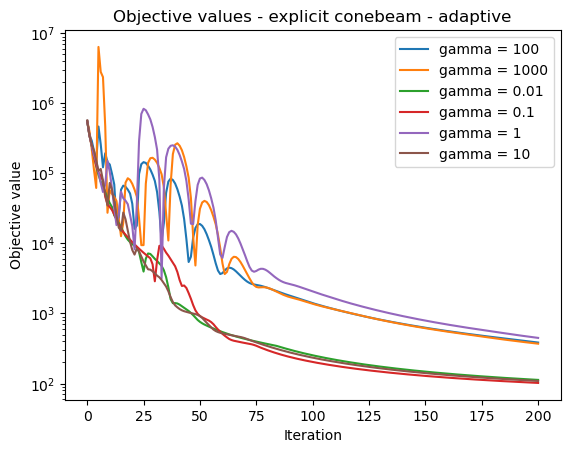

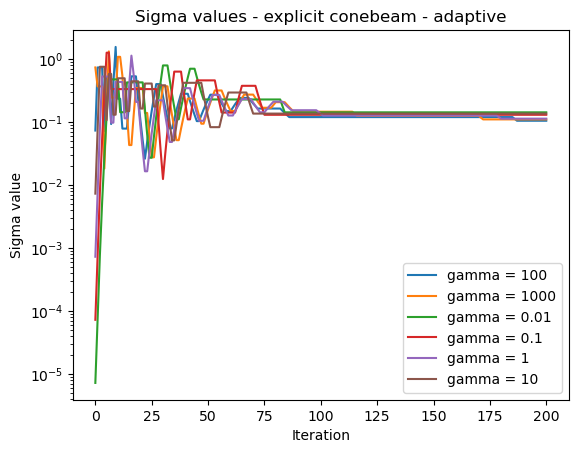

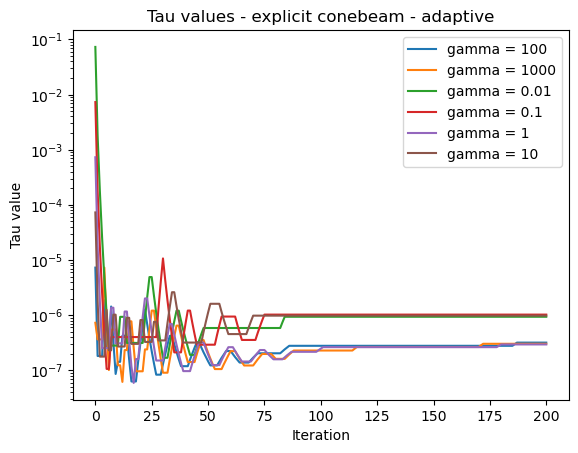

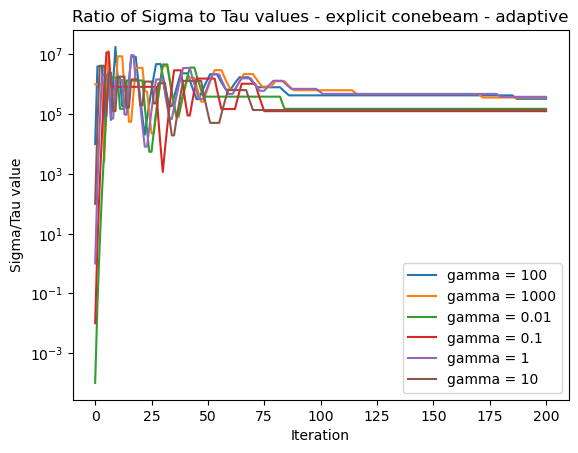

In [22]:
plt.figure()
for i, gamma in enumerate(gamma_list):
    plt.plot(range(0, 201, 1), objective_adaptive[i], label='gamma = ' + str(gamma))
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Objective value')
plt.title('Objective values - explicit conebeam - adaptive')
plt.legend()
plt.show()

plt.figure()
for i, gamma in enumerate(gamma_list):
    plt.plot(range(0, 201, 1), sigma_values[i], label='gamma = ' + str(gamma))
plt.title('Sigma values - explicit conebeam - adaptive')
plt.xlabel('Iteration')
plt.ylabel('Sigma value')
plt.yscale('log')
plt.legend()
plt.show()

plt.figure()
for i, gamma in enumerate(gamma_list):
    plt.plot(range(0, 201, 1), tau_values[i], label='gamma = ' + str(gamma))
plt.title('Tau values - explicit conebeam - adaptive')
plt.xlabel('Iteration')
plt.ylabel('Tau value')
plt.yscale('log')
plt.legend()
plt.show()

plt.figure()
for i, gamma in enumerate(gamma_list):
    #plt the ratio of sigma to tau
    plt.plot(range(0, 201, 1), np.array(sigma_values[i])/np.array(tau_values[i]), label='gamma = ' + str(gamma))
plt.title('Ratio of Sigma to Tau values - explicit conebeam - adaptive')
plt.xlabel('Iteration')
plt.ylabel('Sigma/Tau value')
plt.yscale('log')
plt.legend()
plt.show()

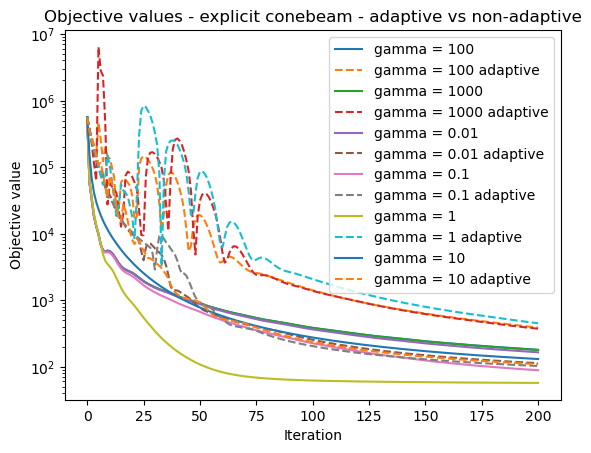

In [23]:
for i, gamma in enumerate(gamma_list):
    plt.plot(range(0, 201, 1), objective_vanilla[i], label='gamma = ' + str(gamma))
    plt.plot(range(0, 201, 1), objective_adaptive[i], label='gamma = ' + str(gamma)+' adaptive', linestyle='dashed')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Objective value')
plt.title('Objective values - explicit conebeam - adaptive vs non-adaptive')
plt.legend()
plt.show()

# Single slice experiments 

New geometry:  2D Cone-beam tomography
System configuration:
	Source position: [     0., -20000.]
	Rotation axis position: [0., 0.]
	Detector position: [    0., 60000.]
	Detector direction x: [1., 0.]
Panel configuration:
	Number of pixels: [128   1]
	Pixel size: [64. 64.]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 60
	Angles 0-9 in degrees: [ 0.,  6., 12., 18., 24., 30., 36., 42., 48., 54.]
	Angles 50-59 in degrees: [300., 306., 312., 318., 324., 330., 336., 342., 348., 354.]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: units distance
Shape out:  (60, 128)
New geometry shape:  (60, 128)
FDK recon

Input Data:
	angle: 60
	horizontal: 128

Reconstruction Volume:
	horizontal_y: 128
	horizontal_x: 128

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 8
	Filter_inplace: False



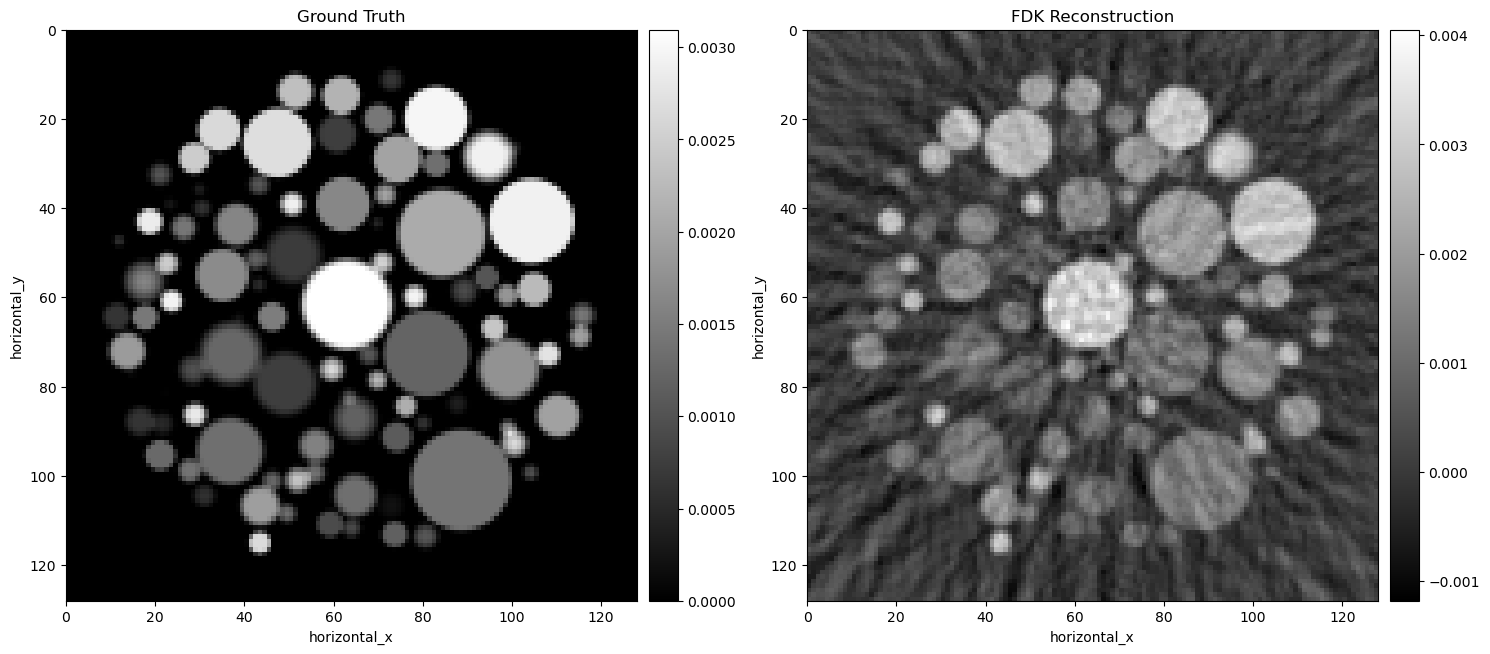

gamma =  100
Initial step sizes: tau = 7.284922274005562e-06, sigma = 0.07284922274005562


  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  0.07439052
x norm =  0.074380614
Backtracking condition value: -0.0008365393034612395
x_tmp norm =  0.019251233
x norm =  0.019246371
Step sizes reduced
Backtracking condition value: 1.3298580556855025e-05
After possible reduction 3.642461137002781e-06 0.03642461137002781
2*self.p_norm < self.d_norm
After adaptive 1.8212305685013922e-07 0.7284922274005555 0.9025
x_tmp norm =  0.025915725
x norm =  0.006697774
Backtracking condition value: 4.065234921744858e-05
After possible reduction 1.8212305685013922e-07 0.7284922274005555
No change
After adaptive 1.8212305685013922e-07 0.7284922274005555 0.9025
x_tmp norm =  0.036763724
x norm =  0.0108625945
Backtracking condition value: 3.249053838517014e-06
After possible reduction 1.8212305685013922e-07 0.7284922274005555
No change
After adaptive 1.8212305685013922e-07 0.7284922274005555 0.9025
x_tmp norm =  0.047952037
x norm =  0.011212123
Backtracking condition value: 7.444854172028735e-05
After possible reduction 1.82123056850

  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  0.04617308
x norm =  0.046172068
Backtracking condition value: -0.00322316517522824
x_tmp norm =  0.01462526
x norm =  0.014624753
Step sizes reduced
Backtracking condition value: 7.671303821047147e-05
After possible reduction 3.642461137002781e-07 0.3642461137002781
No change
After adaptive 3.642461137002781e-07 0.3642461137002781 0.95
x_tmp norm =  0.034740314
x norm =  0.020119939
Backtracking condition value: 2.8576574237469714e-05
After possible reduction 3.642461137002781e-07 0.3642461137002781
No change
After adaptive 3.642461137002781e-07 0.3642461137002781 0.95
x_tmp norm =  0.054364566
x norm =  0.01965316
Backtracking condition value: 0.00012281016665974584
After possible reduction 3.642461137002781e-07 0.3642461137002781
No change
After adaptive 3.642461137002781e-07 0.3642461137002781 0.95
x_tmp norm =  0.07034659
x norm =  0.016087256
Backtracking condition value: 2.541127617431881e-05
After possible reduction 3.642461137002781e-07 0.3642461137002781
2*self.

  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  0.079809226
x norm =  0.0774063
Backtracking condition value: -9.113018770305644e-08
x_tmp norm =  0.01995238
x norm =  0.019351644
Step sizes reduced
Backtracking condition value: 1.589159916613618e-09
After possible reduction 0.03642461137002781 3.642461137002781e-06
2*self.p_norm < self.d_norm
After adaptive 0.001821230568501392 7.284922274005556e-05 0.9025
x_tmp norm =  0.03063534
x norm =  0.01063274
Backtracking condition value: 1.8951561380224447e-08
After possible reduction 0.001821230568501392 7.284922274005556e-05
2*self.p_norm < self.d_norm
After adaptive 0.0001775699804288858 0.0007471715152826209 0.8573749999999999
x_tmp norm =  0.040842757
x norm =  0.011002399
Backtracking condition value: 1.6370226862477424e-07
After possible reduction 0.0001775699804288858 0.0007471715152826209
2*self.p_norm < self.d_norm
After adaptive 2.5325918458669856e-05 0.005238713516442561 0.8145062499999999
x_tmp norm =  0.049472697
x norm =  0.00903137
Backtracking condition valu

  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  0.079803996
x norm =  0.07740122
Backtracking condition value: -9.111823410622115e-07
x_tmp norm =  0.019951725
x norm =  0.019351011
Step sizes reduced
Backtracking condition value: 1.5890551158542352e-08
After possible reduction 0.003642461137002781 3.6424611370027814e-05
2*self.p_norm < self.d_norm
After adaptive 0.00018212305685013922 0.0007284922274005556 0.9025
x_tmp norm =  0.030627534
x norm =  0.011296533
Backtracking condition value: 1.6350673771018676e-07
After possible reduction 0.00018212305685013922 0.0007284922274005556
2*self.p_norm < self.d_norm
After adaptive 1.775699804288858e-05 0.007471715152826209 0.8573749999999999
x_tmp norm =  0.041218586
x norm =  0.010866655
Backtracking condition value: 1.3957875803820547e-06
After possible reduction 1.775699804288858e-05 0.007471715152826209
2*self.p_norm < self.d_norm
After adaptive 2.5325918458669857e-06 0.05238713516442561 0.8145062499999999
x_tmp norm =  0.049615767
x norm =  0.008561951
Backtracking condi

  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  0.079751715
x norm =  0.07902172
Backtracking condition value: -9.502082949235117e-06
x_tmp norm =  0.019945187
x norm =  0.019617653
Step sizes reduced
Backtracking condition value: 1.4958792576458535e-07
After possible reduction 0.00036424611370027807 0.00036424611370027807
2*self.p_norm < self.d_norm
After adaptive 1.821230568501392e-05 0.007284922274005555 0.9025
x_tmp norm =  0.030825267
x norm =  0.011295264
Backtracking condition value: 1.468179701764511e-06
After possible reduction 1.821230568501392e-05 0.007284922274005555
2*self.p_norm < self.d_norm
After adaptive 1.7756998042888579e-06 0.07471715152826208 0.8573749999999999
x_tmp norm =  0.040906273
x norm =  0.010157124
Backtracking condition value: 1.1374992900000357e-05
After possible reduction 1.7756998042888579e-06 0.07471715152826208
2*self.p_norm < self.d_norm
After adaptive 2.5325918458669857e-07 0.5238713516442561 0.8145062499999999
x_tmp norm =  0.046870653
x norm =  0.006021642
Backtracking condition

  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  0.07923261
x norm =  0.07914304
Backtracking condition value: -9.478469591211162e-05
x_tmp norm =  0.01988004
x norm =  0.019837439
Step sizes reduced
Backtracking condition value: 1.4250473029146683e-06
After possible reduction 3.6424611370027814e-05 0.003642461137002781
2*self.p_norm < self.d_norm
After adaptive 1.8212305685013922e-06 0.07284922274005556 0.9025
x_tmp norm =  0.030337522
x norm =  0.010547847
Backtracking condition value: 1.2158134712068687e-05
After possible reduction 1.8212305685013922e-06 0.07284922274005556
2*self.p_norm < self.d_norm
After adaptive 1.775699804288858e-07 0.7471715152826209 0.8573749999999999
x_tmp norm =  0.036700793
x norm =  0.0063829734
Backtracking condition value: 3.4435580383330023e-05
After possible reduction 1.775699804288858e-07 0.7471715152826209
No change
After adaptive 1.775699804288858e-07 0.7471715152826209 0.8573749999999999
x_tmp norm =  0.04583105
x norm =  0.009150602
Backtracking condition value: 1.1448935942592718

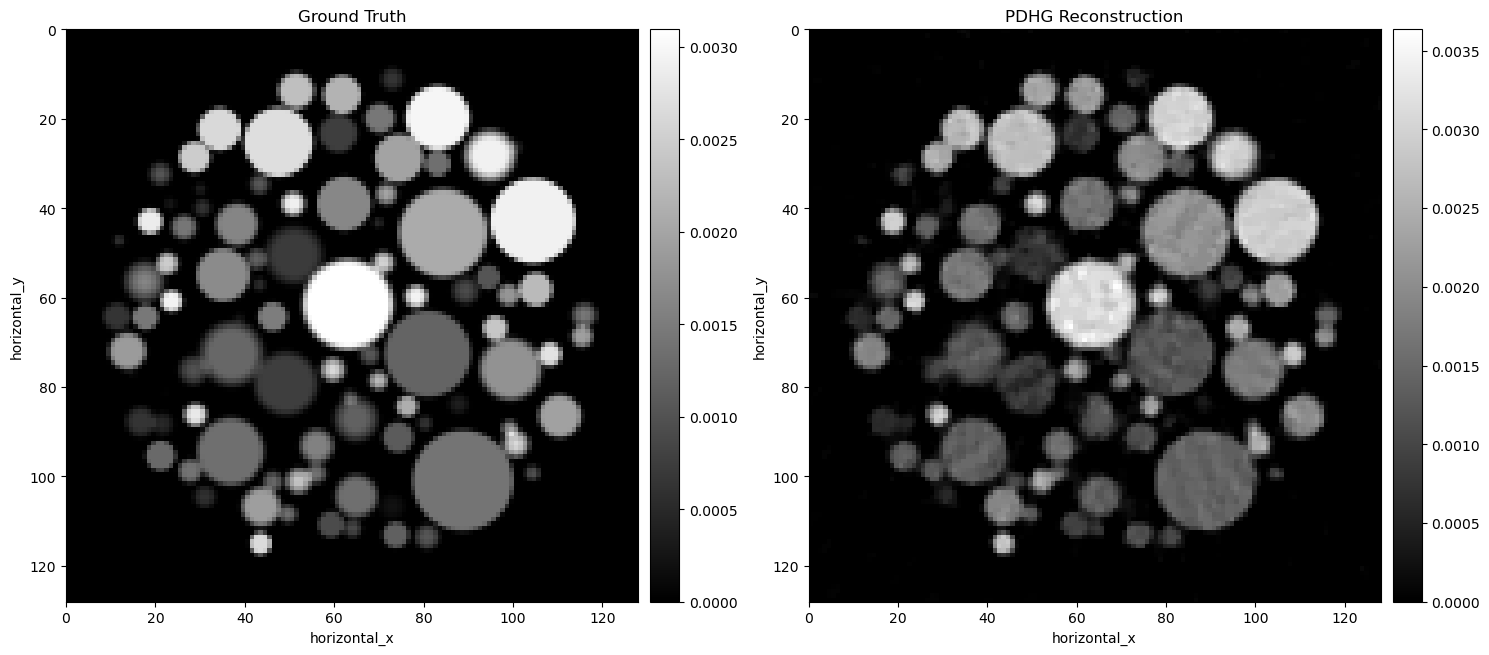

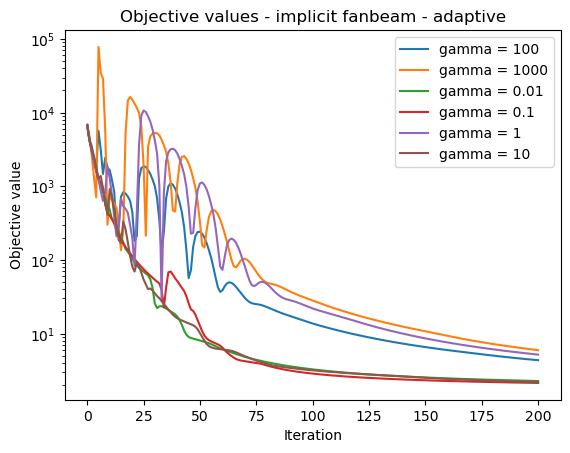

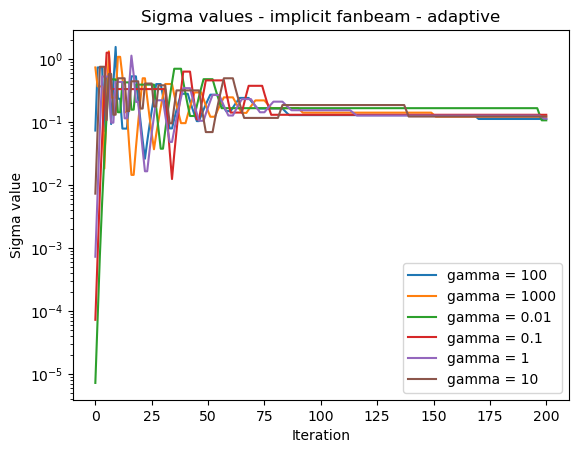

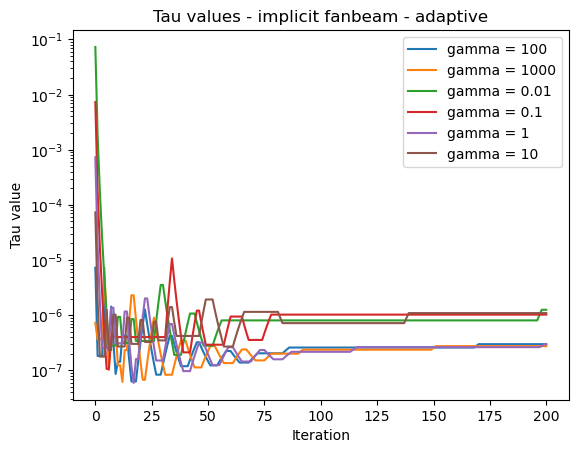

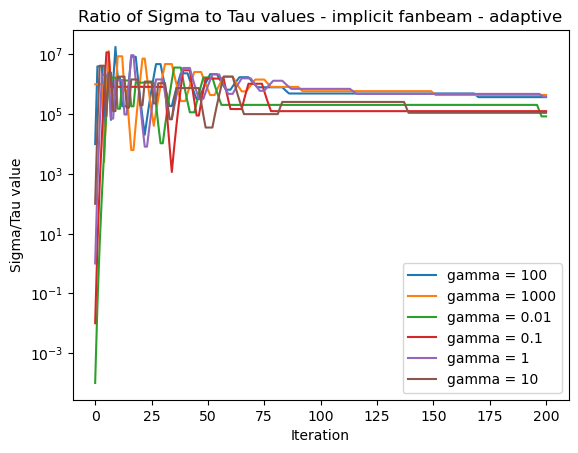

gamma =  0.01
Initial step sizes: tau = 0.07284922274005562, sigma = 7.284922274005562e-06


  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  0.079809226
x norm =  0.0774063
x_tmp norm =  0.0854796
x norm =  0.010625762
x_tmp norm =  0.09169788
x norm =  0.009451337
x_tmp norm =  0.098432355
x norm =  0.0070842844
x_tmp norm =  0.104422376
x norm =  0.0054321177
x_tmp norm =  0.10945388
x norm =  0.004483907
x_tmp norm =  0.113906674
x norm =  0.0034797362
x_tmp norm =  0.11810509
x norm =  0.0023898522
x_tmp norm =  0.12222591
x norm =  0.0019816202
x_tmp norm =  0.12644656
x norm =  0.0019741892
x_tmp norm =  0.13076904
x norm =  0.0021813756
x_tmp norm =  0.13519078
x norm =  0.0020425322
x_tmp norm =  0.13964902
x norm =  0.0018769072
x_tmp norm =  0.14418049
x norm =  0.0017568254
x_tmp norm =  0.14884192
x norm =  0.0018613571
x_tmp norm =  0.15364592
x norm =  0.0017887476
x_tmp norm =  0.15855679
x norm =  0.0017091148
x_tmp norm =  0.16357848
x norm =  0.0017599908
x_tmp norm =  0.16872078
x norm =  0.0016906076
x_tmp norm =  0.1739586
x norm =  0.0021311878
x_tmp norm =  0.17928766
x norm =  0.0017844

  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  0.079803996
x norm =  0.07740122
x_tmp norm =  0.08547841
x norm =  0.010829389
x_tmp norm =  0.091798425
x norm =  0.012334412
x_tmp norm =  0.099710695
x norm =  0.013995721
x_tmp norm =  0.107883915
x norm =  0.014396264
x_tmp norm =  0.115580276
x norm =  0.013101012
x_tmp norm =  0.12215609
x norm =  0.010215372
x_tmp norm =  0.1264947
x norm =  0.008665108
x_tmp norm =  0.12946387
x norm =  0.008086476
x_tmp norm =  0.13215616
x norm =  0.008185199
x_tmp norm =  0.13534121
x norm =  0.008235324
x_tmp norm =  0.13896157
x norm =  0.008105056
x_tmp norm =  0.14268002
x norm =  0.007346738
x_tmp norm =  0.14622872
x norm =  0.0064047356
x_tmp norm =  0.1494054
x norm =  0.0055876835
x_tmp norm =  0.1520499
x norm =  0.004939488
x_tmp norm =  0.15410373
x norm =  0.0044961832
x_tmp norm =  0.15557161
x norm =  0.004290061
x_tmp norm =  0.15650317
x norm =  0.0041755363
x_tmp norm =  0.15699051
x norm =  0.004160913
x_tmp norm =  0.15715654
x norm =  0.004133593
x_tmp no

  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  0.079751715
x norm =  0.07902172
x_tmp norm =  0.08574148
x norm =  0.018669719
x_tmp norm =  0.09480083
x norm =  0.019572757
x_tmp norm =  0.10500219
x norm =  0.018200444
x_tmp norm =  0.11448207
x norm =  0.01559479
x_tmp norm =  0.12068582
x norm =  0.014209799
x_tmp norm =  0.12549233
x norm =  0.014069895
x_tmp norm =  0.1311213
x norm =  0.012847336
x_tmp norm =  0.13699327
x norm =  0.011084985
x_tmp norm =  0.14202635
x norm =  0.009330157
x_tmp norm =  0.14549433
x norm =  0.008345396
x_tmp norm =  0.14746977
x norm =  0.007851237
x_tmp norm =  0.14813052
x norm =  0.00792688
x_tmp norm =  0.14776164
x norm =  0.0081858095
x_tmp norm =  0.14687398
x norm =  0.008186781
x_tmp norm =  0.14582732
x norm =  0.00786216
x_tmp norm =  0.14483817
x norm =  0.0072042467
x_tmp norm =  0.14398707
x norm =  0.006458444
x_tmp norm =  0.14333072
x norm =  0.005748197
x_tmp norm =  0.14295174
x norm =  0.0051753544
x_tmp norm =  0.14286077
x norm =  0.0048537636
x_tmp norm = 

  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  0.07923261
x norm =  0.07914304
x_tmp norm =  0.0857565
x norm =  0.020188408
x_tmp norm =  0.09572515
x norm =  0.020943746
x_tmp norm =  0.106987946
x norm =  0.019060856
x_tmp norm =  0.11665514
x norm =  0.016658522
x_tmp norm =  0.123658694
x norm =  0.01574893
x_tmp norm =  0.13015027
x norm =  0.014654644
x_tmp norm =  0.13669813
x norm =  0.012276148
x_tmp norm =  0.14173946
x norm =  0.010030842
x_tmp norm =  0.14487474
x norm =  0.008177434
x_tmp norm =  0.14631996
x norm =  0.0073157456
x_tmp norm =  0.14666195
x norm =  0.0070678676
x_tmp norm =  0.14638463
x norm =  0.0071239984
x_tmp norm =  0.14580762
x norm =  0.0071210535
x_tmp norm =  0.14510319
x norm =  0.006975455
x_tmp norm =  0.14437027
x norm =  0.006592131
x_tmp norm =  0.14368021
x norm =  0.0060322084
x_tmp norm =  0.14308031
x norm =  0.0054009953
x_tmp norm =  0.1426012
x norm =  0.004835954
x_tmp norm =  0.14226477
x norm =  0.0044393283
x_tmp norm =  0.14207862
x norm =  0.004239617
x_tmp no

  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  0.07439052
x norm =  0.074380614
x_tmp norm =  0.08450415
x norm =  0.019510312
x_tmp norm =  0.09353572
x norm =  0.01927653
x_tmp norm =  0.10335033
x norm =  0.017342627
x_tmp norm =  0.111936785
x norm =  0.015060442
x_tmp norm =  0.1184407
x norm =  0.01354475
x_tmp norm =  0.12381716
x norm =  0.012404262
x_tmp norm =  0.12892106
x norm =  0.010541569
x_tmp norm =  0.13318773
x norm =  0.008604235
x_tmp norm =  0.13614982
x norm =  0.006963846
x_tmp norm =  0.13789646
x norm =  0.005908713
x_tmp norm =  0.13873217
x norm =  0.0053788316
x_tmp norm =  0.13898888
x norm =  0.005117286
x_tmp norm =  0.13888429
x norm =  0.0049254773
x_tmp norm =  0.13855448
x norm =  0.0047044572
x_tmp norm =  0.13811041
x norm =  0.0043965243
x_tmp norm =  0.13764036
x norm =  0.0040044147
x_tmp norm =  0.13720421
x norm =  0.0035805043
x_tmp norm =  0.13684098
x norm =  0.003178835
x_tmp norm =  0.13656609
x norm =  0.0028573796
x_tmp norm =  0.1363774
x norm =  0.0026366166
x_tmp no

  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  0.04617308
x norm =  0.046172068
x_tmp norm =  0.06720932
x norm =  0.02178567
x_tmp norm =  0.07801323
x norm =  0.0127856
x_tmp norm =  0.08450696
x norm =  0.0093114115
x_tmp norm =  0.08902396
x norm =  0.0075351223
x_tmp norm =  0.09251449
x norm =  0.006354191
x_tmp norm =  0.09539324
x norm =  0.0054644137
x_tmp norm =  0.09785257
x norm =  0.0047634467
x_tmp norm =  0.099999845
x norm =  0.0041938694
x_tmp norm =  0.101905115
x norm =  0.0037187897
x_tmp norm =  0.10361024
x norm =  0.0033226938
x_tmp norm =  0.105147526
x norm =  0.0029912302
x_tmp norm =  0.1065476
x norm =  0.0027097727
x_tmp norm =  0.10782965
x norm =  0.0024697897
x_tmp norm =  0.109010875
x norm =  0.002261375
x_tmp norm =  0.11010134
x norm =  0.0020799118
x_tmp norm =  0.11111093
x norm =  0.0019211204
x_tmp norm =  0.112047136
x norm =  0.0017824473
x_tmp norm =  0.112918705
x norm =  0.0016589524
x_tmp norm =  0.11373129
x norm =  0.001549102
x_tmp norm =  0.11448998
x norm =  0.0014512

  0%|          | 0/200 [00:00<?, ?it/s]

x_tmp norm =  0.0796937
x norm =  0.07929992
x_tmp norm =  0.08576828
x norm =  0.01946825
x_tmp norm =  0.09529111
x norm =  0.020231111
x_tmp norm =  0.10596673
x norm =  0.018586947
x_tmp norm =  0.115556344
x norm =  0.01610677
x_tmp norm =  0.122051045
x norm =  0.01510804
x_tmp norm =  0.12769327
x norm =  0.014652321
x_tmp norm =  0.1340132
x norm =  0.013047967
x_tmp norm =  0.14010364
x norm =  0.010856799
x_tmp norm =  0.14446293
x norm =  0.009207314
x_tmp norm =  0.14712994
x norm =  0.007851489
x_tmp norm =  0.14802736
x norm =  0.0076843225
x_tmp norm =  0.14777464
x norm =  0.007873283
x_tmp norm =  0.14705804
x norm =  0.007932517
x_tmp norm =  0.14620695
x norm =  0.0076906895
x_tmp norm =  0.14528327
x norm =  0.0072933794
x_tmp norm =  0.1444098
x norm =  0.0067216908
x_tmp norm =  0.14369665
x norm =  0.006053487
x_tmp norm =  0.14320357
x norm =  0.0054077036
x_tmp norm =  0.14293955
x norm =  0.0049412567
x_tmp norm =  0.14287241
x norm =  0.0047122086
x_tmp norm 

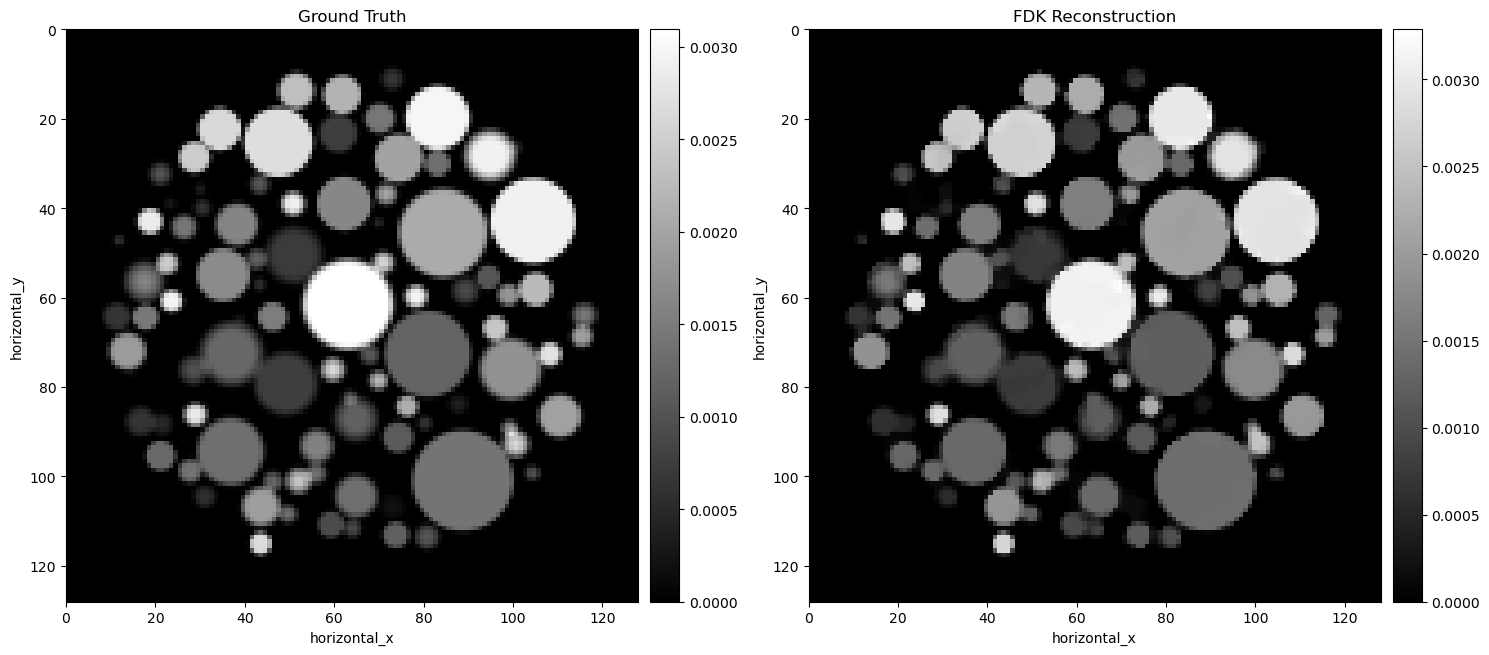

IndexError: list index out of range

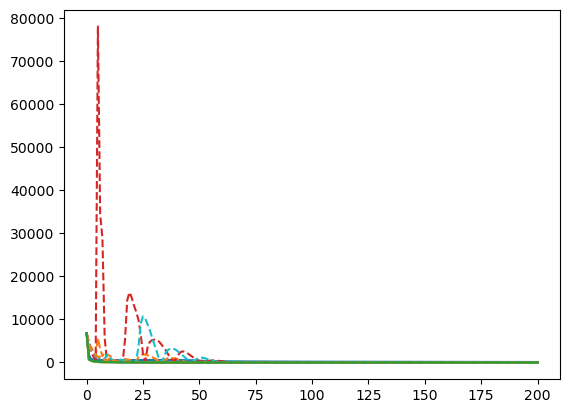

In [24]:
ground_truth = dataexample.SIMULATED_SPHERE_VOLUME.get()

data = dataexample.SIMULATED_CONE_BEAM_DATA.get()
data = data.get_slice(vertical='centre')
ground_truth = ground_truth.get_slice(vertical='centre')


absorption = TransmissionAbsorptionConverter()(data)
absorption = Slicer(roi={'angle':(0, -1, 5)})(absorption)

ig = ground_truth.geometry

recon = FDK(absorption, image_geometry=ig).run()
show2D([ground_truth, recon], title = ['Ground Truth', 'FDK Reconstruction'], origin = 'upper', num_cols = 2);
from cil.optimisation.utilities.callbacks import Callback, ProgressCallback

class SaveStepSizes(Callback):
    def __init__(self):
        super().__init__()
        self.tau = []
        self.sigma = []

    def __call__(self, algorithm):
        self.tau.append(algorithm.tau)
        self.sigma.append(algorithm.sigma)
A = ProjectionOperator(ig, absorption.geometry, device = "gpu")

#  PDHG with implicit TV regularisation - adaptive vs non-adaptive - changing gamma 
F = 0.5 * L2NormSquared(b=absorption)
alpha = 0.5
G = alpha *  FGP_TV( device='gpu', nonnegativity=True)
rho = 1.0

gamma_list =  [ 100, 1000,  0.01, 0.1, 1, 10]
results_adaptive = []
objective_adaptive = []
sigma_values = []
tau_values = []
for gamma in gamma_list:
    print("gamma = ", gamma)
    sigma = gamma*rho/A.norm()
    tau =(rho/gamma)/A.norm() 
    pdhg_tv_implicit = PDHG(f = F, g = G, operator = A,
                update_objective_interval = 1, check_convergence=False, sigma=sigma, tau=tau, adaptive=True)#, eta=.95, initial=[recon, None]) 
    callback=SaveStepSizes()
    pdhg_tv_implicit.run(200, verbose=1, callbacks=[ProgressCallback(), callback])
    results_adaptive.append(pdhg_tv_implicit.solution)
    objective_adaptive.append(pdhg_tv_implicit.objective)
    sigma_values.append(callback.sigma)
    tau_values.append(callback.tau)
    

show2D([ground_truth, pdhg_tv_implicit.solution], title = ['Ground Truth', 'PDHG Reconstruction'], origin = 'upper', num_cols = 2);
plt.figure()
for i, gamma in enumerate(gamma_list):
    plt.plot(range(0, 201, 1), objective_adaptive[i], label='gamma = ' + str(gamma))
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Objective value')
plt.title('Objective values - implicit fanbeam - adaptive')
plt.legend()
plt.show()

plt.figure()
for i, gamma in enumerate(gamma_list):
    plt.plot(range(0, 201, 1), sigma_values[i], label='gamma = ' + str(gamma))
plt.title('Sigma values - implicit fanbeam - adaptive')
plt.xlabel('Iteration')
plt.ylabel('Sigma value')
plt.yscale('log')
plt.legend()
plt.show()

plt.figure()
for i, gamma in enumerate(gamma_list):
    plt.plot(range(0, 201, 1), tau_values[i], label='gamma = ' + str(gamma))
plt.title('Tau values - implicit fanbeam - adaptive')
plt.xlabel('Iteration')
plt.ylabel('Tau value')
plt.yscale('log')
plt.legend()
plt.show()

plt.figure()
for i, gamma in enumerate(gamma_list):
    #plt the ratio of sigma to tau
    plt.plot(range(0, 201, 1), np.array(sigma_values[i])/np.array(tau_values[i]), label='gamma = ' + str(gamma))
plt.title('Ratio of Sigma to Tau values - implicit fanbeam - adaptive')
plt.xlabel('Iteration')
plt.ylabel('Sigma/Tau value')
plt.yscale('log')
plt.legend()
plt.show()
F = 0.5 * L2NormSquared(b=absorption)
alpha = 0.5
G = alpha *  FGP_TV( device='gpu', nonnegativity=True)
rho = 1.0

gamma_list = [0.01, 0.1, 1, 10, 100, 1000, 1/alpha]
results_vanilla = []
objective_vanilla = []
for gamma in gamma_list:
    print("gamma = ", gamma)
    sigma = gamma*rho/A.norm()
    tau =(rho/gamma)/A.norm() 
    pdhg_tv_implicit = PDHG(f = F, g = G, operator = A,
                update_objective_interval = 1, check_convergence=False, sigma=sigma, tau=tau)
    pdhg_tv_implicit.run(200, verbose=1)
    results_vanilla.append(pdhg_tv_implicit.solution)
    objective_vanilla.append(pdhg_tv_implicit.objective)
    
show2D([ground_truth, pdhg_tv_implicit.solution], title = ['Ground Truth', 'FDK Reconstruction'], origin = 'upper', num_cols = 2);
for i, gamma in enumerate(gamma_list):
    plt.plot(range(0, 201, 1), objective_vanilla[i], label='gamma = ' + str(gamma))
    plt.plot(range(0, 201, 1), objective_adaptive[i], label='gamma = ' + str(gamma)+' adaptive', linestyle='dashed')
plt.title('Objective values - implicit fanbeam - adaptive vs non-adaptive')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Objective value')
plt.legend()
plt.show()
# PDHG with Explicit TV - adaptive vs non-adaptive

#   Vanilla TV with reg parameter in front of gradient operator

alpha = 0.5
G = IndicatorBox(lower=0)
rho = 1.0
f1 =  MixedL21Norm()
f2 = 0.5 * L2NormSquared(b=absorption)
F = BlockFunction(f1, f2)

# Define BlockOperator K
Grad = alpha * GradientOperator(ig)
K = BlockOperator(Grad, A)



gamma_list = [0.01, 0.1, 1, 10, 100, 1000, 1/alpha]
results_vanilla = []
objective_vanilla = []
for gamma in gamma_list:
    print("gamma = ", gamma)
    sigma = gamma*rho/K.norm()
    tau =(rho/gamma)/K.norm() 
    pdhg_tv_explicit = PDHG(f = F, g = G, operator = K,
                update_objective_interval = 1, check_convergence=False, sigma=sigma, tau=tau)
    pdhg_tv_explicit.run(200, verbose=1)
    results_vanilla.append(pdhg_tv_explicit.solution)
    objective_vanilla.append(pdhg_tv_explicit.objective)
    


for i, gamma in enumerate(gamma_list):
    plt.plot(range(0, 201, 1), objective_vanilla[i], label='gamma = ' + str(gamma))
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Objective value')
plt.title('Objective values - explicit fanbeam - non-adaptive')
plt.legend()
plt.show()

show2D([ground_truth, pdhg_tv_explicit.solution], title = ['Ground Truth', 'FDK Reconstruction'], origin = 'upper', num_cols = 2);

print( F(K.direct(pdhg_tv_explicit.solution)) )
print( G(pdhg_tv_explicit.solution) )

alpha = 0.5
G = IndicatorBox(lower=0)
rho = 1.0
f1 =  MixedL21Norm()
f2 = 0.5 * L2NormSquared(b=absorption)
F = BlockFunction(f1, f2)

# Define BlockOperator K
Grad = alpha * GradientOperator(ig)
K = BlockOperator(Grad, A)


gamma_list =  [ 100, 1000,  1/A.norm(), 0.01, 0.1, 1, 10]
results_adaptive = []
objective_adaptive = []
sigma_values = []
tau_values = []
for gamma in gamma_list:
    print("gamma = ", gamma)
    sigma = gamma*rho/A.norm()
    tau =(rho/gamma)/A.norm() 
    pdhg_tv_explicit = PDHG(f = F, g = G, operator = K,
                update_objective_interval = 1, check_convergence=False, sigma=sigma, tau=tau, adaptive=True)#, eta=.95, initial=[recon, None]) 
    callback=SaveStepSizes()
    pdhg_tv_explicit.run(200, verbose=1, callbacks=[ProgressCallback(), callback])
    results_adaptive.append(pdhg_tv_explicit.solution)
    objective_adaptive.append(pdhg_tv_explicit.objective)
    sigma_values.append(callback.sigma)
    tau_values.append(callback.tau)
    
plt.figure()
for i, gamma in enumerate(gamma_list):
    plt.plot(range(0, 201, 1), objective_adaptive[i], label='gamma = ' + str(gamma))
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Objective value')
plt.title('Objective values - explicit fanbeam - adaptive')
plt.legend()
plt.show()

plt.figure()
for i, gamma in enumerate(gamma_list):
    plt.plot(range(0, 201, 1), sigma_values[i], label='gamma = ' + str(gamma))
plt.title('Sigma values - explicit fanbeam - adaptive')
plt.xlabel('Iteration')
plt.ylabel('Sigma value')
plt.yscale('log')
plt.legend()
plt.show()

plt.figure()
for i, gamma in enumerate(gamma_list):
    plt.plot(range(0, 201, 1), tau_values[i], label='gamma = ' + str(gamma))
plt.title('Tau values  - explicit fanbeam - adaptive')
plt.xlabel('Iteration')
plt.ylabel('Tau value')
plt.yscale('log')
plt.legend()
plt.show()

plt.figure()
for i, gamma in enumerate(gamma_list):
    #plt the ratio of sigma to tau
    plt.plot(range(0, 201, 1), np.array(sigma_values[i])/np.array(tau_values[i]), label='gamma = ' + str(gamma))
plt.title('Ratio of Sigma to Tau values - explicit fanbeam - adaptive')
plt.xlabel('Iteration')
plt.ylabel('Sigma/Tau value')
plt.yscale('log')
plt.legend()
plt.show()
for i, gamma in enumerate(gamma_list):
    plt.plot(range(0, 201, 1), objective_vanilla[i], label='gamma = ' + str(gamma))
    plt.plot(range(0, 201, 1), objective_adaptive[i], label='gamma = ' + str(gamma)+' adaptive', linestyle='dashed')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Objective value')
plt.title('Objective values - explicit fanbeam - adaptive vs non-adaptive')
plt.legend()
plt.show()


In [ ]:
# Walnut data

In [ ]:
from cil.io import ZEISSDataReader
from cil.utilities.display import show2D, show1D, show_geometry
from cil.processors import Binner
from cil.plugins.astra.processors import FBP

filename = "/mnt/share-private/notebooks/valnut/valnut_2014-03-21_643_28/tomo-A/valnut_tomo-A.txrm"
data3D = ZEISSDataReader(file_name=filename).read()
# Get Image and Acquisition geometries
ag3D = data3D.geometry
ig3D = ag3D.get_ImageGeometry()
### Acquisition and Image geometry information
print(ag3D)
print(ig3D)
### Show Acquisition geometry and full 3D sinogram.
show_geometry(ag3D)
show2D(data3D, slice_list = [('vertical',512), ('angle',800), ('horizontal',512)], cmap="inferno", num_cols=3, size=(15,15))


# Extract vertical slice
data2D = data3D.get_slice(vertical='centre')

# delete the 3D data to save memory
del data3D

# reorder data to match default order for Astra/Tigre operator
data2D.reorder('astra')

# Select every 10 angles
sliced_data = Slicer(roi={'angle':(0,1600,10)})(data2D)

# Reduce background regions
binned_data = Binner(roi={'horizontal':(120,-120,2)})(sliced_data)

# Create absorption data 
absorption_data = TransmissionAbsorptionConverter()(binned_data) 

# Remove circular artifacts
absorption_data -= np.mean(absorption_data.as_array()[80:100,0:30])
# Get Image and Acquisition geometries for one slice
ag2D = absorption_data.geometry
ag2D.set_angles(ag2D.angles, initial_angle=0.2, angle_unit='radian')
ig2D = ag2D.get_ImageGeometry()
print(" Acquisition Geometry 2D: {} with labels {}".format(ag2D.shape, ag2D.dimension_labels))
print(" Image Geometry 2D: {} with labels {}".format(ig2D.shape, ig2D.dimension_labels))
#

# Setup and run the FBP algorithm
fbp_recon = FBP(ig2D, ag2D,  device = 'gpu')(absorption_data)



# Show reconstructions
show2D([fbp_recon], 
       title = ['FBP reconstruction'], 
       cmap = 'inferno', fix_range=(0,0.05))

A = ProjectionOperator(ig2D, ag2D, device = "gpu")
alpha_tv = 0.0003
f1 =  MixedL21Norm()
f2 = 0.5 * L2NormSquared(b=absorption_data)
F = BlockFunction(f1, f2)

# Define BlockOperator K
Grad = alpha_tv * GradientOperator(ig2D)
K = BlockOperator(Grad, A)

# Define Function G
G = IndicatorBox(lower=0)



gamma_list =  [ 100, 1000,  1/A.norm(), 0.01, 0.1, 1, 10]
rho=0.99
results_adaptive = []
objective_adaptive = []
sigma_values = []
tau_values = []
for gamma in gamma_list:
    print("gamma = ", gamma)
    sigma = gamma*rho/A.norm()
    tau =(rho/gamma)/A.norm() 
    pdhg_tv_explicit = PDHG(f = F, g = G, operator = K,
                update_objective_interval = 1, check_convergence=False, sigma=sigma, tau=tau, adaptive=True)#, eta=.95, initial=[recon, None]) 
    callback=SaveStepSizes()
    pdhg_tv_explicit.run(200, verbose=1, callbacks=[ProgressCallback(), callback])
    results_adaptive.append(pdhg_tv_explicit.solution)
    objective_adaptive.append(pdhg_tv_explicit.objective)
    sigma_values.append(callback.sigma)
    tau_values.append(callback.tau)
    

show2D([ground_truth, pdhg_tv_explicit.solution], title = ['Ground Truth', 'PDHG Reconstruction'], origin = 'upper', num_cols = 2);
plt.figure()
for i, gamma in enumerate(gamma_list):
    plt.plot(range(0, 201, 1), objective_adaptive[i], label='gamma = ' + str(gamma))
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Objective value')
plt.title('Objective value - walnut slice implicit TV - adaptive')
plt.legend()
plt.show()

plt.figure()
for i, gamma in enumerate(gamma_list):
    plt.plot(range(0, 201, 1), sigma_values[i], label='gamma = ' + str(gamma))
plt.title('Sigma value - walnut slice explicit TV - adaptive')
plt.xlabel('Iteration')
plt.ylabel('Sigma value')
plt.yscale('log')
plt.legend()
plt.show()

plt.figure()
for i, gamma in enumerate(gamma_list):
    plt.plot(range(0, 201, 1), tau_values[i], label='gamma = ' + str(gamma))
plt.title('Tau value - walnut slice explicit TV - adaptive')
plt.xlabel('Iteration')
plt.ylabel('Tau value')
plt.yscale('log')
plt.legend()
plt.show()

plt.figure()
for i, gamma in enumerate(gamma_list):
    #plt the ratio of sigma to tau
    plt.plot(range(0, 201, 1), np.array(sigma_values[i])/np.array(tau_values[i]), label='gamma = ' + str(gamma))
plt.title('Ratio of Sigma to Tau values - walnut slice explicit TV - adaptive')
plt.xlabel('Iteration')
plt.ylabel('Sigma/Tau value ')
plt.yscale('log')
plt.legend()
plt.show()



gamma_list = [0.01, 0.1, 1, 10, 100, 1000, 1/alpha]
results_vanilla = []
objective_vanilla = []
for gamma in gamma_list:
    print("gamma = ", gamma)
    sigma = gamma*rho/A.norm()
    tau =(rho/gamma)/A.norm() 
    pdhg_tv_explicit = PDHG(f = F, g = G, operator = K,
                update_objective_interval = 1, check_convergence=False, sigma=sigma, tau=tau)
    pdhg_tv_explicit.run(200, verbose=1)
    results_vanilla.append(pdhg_tv_explicit.solution)
    objective_vanilla.append(pdhg_tv_explicit.objective)
    
show2D([ground_truth, pdhg_tv_explicit.solution], title = ['Ground Truth', 'FDK Reconstruction'], origin = 'upper', num_cols = 2);
for i, gamma in enumerate(gamma_list):
    plt.plot(range(0, 201, 1), objective_vanilla[i], label='gamma = ' + str(gamma))
    plt.plot(range(0, 201, 1), objective_adaptive[i], label='gamma = ' + str(gamma)+' adaptive', linestyle='dashed')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Objective value')
plt.title('Objective value - walnut slice explicit TV - adaptive vs non-adaptive')
plt.legend()
plt.show()




# PDHG with Implicit TV - adaptive vs non-adaptive
# Vanilla TV with reg parameter in front of Mixed L21 Norm

F = 0.5 * L2NormSquared(b=absorption_data)
G = (alpha_tv/ig2D.voxel_size_y) * FGP_TV(max_iteration=100, device='gpu', nonnegativity=True)
K = A



gamma_list = [0.01, 0.1, 1, 10, 100, 1000, 1/alpha]
results_vanilla = []
objective_vanilla = []
for gamma in gamma_list:
    print("gamma = ", gamma)
    sigma = gamma*rho/K.norm()
    tau =(rho/gamma)/K.norm() 
    pdhg_tv_implicit = PDHG(f = F, g = G, operator = K,
                update_objective_interval = 1, check_convergence=False, sigma=sigma, tau=tau)
    pdhg_tv_implicit.run(200, verbose=1)
    results_vanilla.append(pdhg_tv_implicit.solution)
    objective_vanilla.append(pdhg_tv_implicit.objective)



    
for i, gamma in enumerate(gamma_list):
    plt.plot(range(0, 201, 1), objective_vanilla[i], label='gamma = ' + str(gamma))
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Objective value')
plt.legend()
plt.title('Vanilla implicit TV - walnut slice')
plt.show()

show2D([ground_truth, pdhg_tv_implicit.solution], title = ['Ground Truth', 'FDK Reconstruction'], origin = 'upper', num_cols = 2);

print( F(K.direct(pdhg_tv_implicit.solution)) )
print( G(pdhg_tv_explicit.solution) )



gamma_list =  [ 100, 1000,  1/A.norm(), 0.01, 0.1, 1, 10]
results_adaptive = []
objective_adaptive = []
sigma_values = []
tau_values = []
for gamma in gamma_list:
    print("gamma = ", gamma)
    sigma = gamma*rho/A.norm()
    tau =(rho/gamma)/A.norm() 
    pdhg_tv_implicit_adaptive = PDHG(f = F, g = G, operator = K,
                update_objective_interval = 1, check_convergence=False, sigma=sigma, tau=tau, adaptive=True)#, eta=.95, initial=[recon, None]) 
    callback=SaveStepSizes()
    pdhg_tv_implicit_adaptive.run(200, verbose=1, callbacks=[ProgressCallback(), callback])
    results_adaptive.append(pdhg_tv_implicit_adaptive.solution)
    objective_adaptive.append(pdhg_tv_implicit_adaptive.objective)
    sigma_values.append(callback.sigma)
    tau_values.append(callback.tau)
    
plt.figure()
for i, gamma in enumerate(gamma_list):
    plt.plot(range(0, 201, 1), objective_adaptive[i], label='gamma = ' + str(gamma))
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Objective value')
plt.title('Objective value - walnut slice implicit TV - adaptive')
plt.legend()
plt.show()

plt.figure()
for i, gamma in enumerate(gamma_list):
    plt.plot(range(0, 201, 1), sigma_values[i], label='gamma = ' + str(gamma))
plt.title('Sigma value - walnut slice implicit TV - adaptive')
plt.xlabel('Iteration')
plt.ylabel('Sigma value ')
plt.yscale('log')
plt.legend()
plt.show()

plt.figure()
for i, gamma in enumerate(gamma_list):
    plt.plot(range(0, 201, 1), tau_values[i], label='gamma = ' + str(gamma))
plt.title('Tau value - walnut slice implicit TV - adaptive')
plt.xlabel('Iteration')
plt.ylabel('Tau value ')
plt.yscale('log')
plt.legend()
plt.show()

plt.figure()
for i, gamma in enumerate(gamma_list):
    #plt the ratio of sigma to tau
    plt.plot(range(0, 201, 1), np.array(sigma_values[i])/np.array(tau_values[i]), label='gamma = ' + str(gamma))
plt.title('Ratio of Sigma to Tau values - walnut slice implicit TV - adaptive')
plt.xlabel('Iteration')
plt.ylabel('Sigma/Tau value ')
plt.yscale('log')
plt.legend()
plt.show()
for i, gamma in enumerate(gamma_list):
    plt.plot(range(0, 201, 1), objective_vanilla[i], label='gamma = ' + str(gamma))
    plt.plot(range(0, 201, 1), objective_adaptive[i], label='gamma = ' + str(gamma)+' adaptive', linestyle='dashed')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Objective value ')
plt.title('Objective value - walnut slice implicit TV - adaptive vs non-adaptive')
plt.legend()
plt.show()